# WEO Economic Data Analysis & Recession Prediction

**Objective:** Load World Economic Outlook (WEO) data, clean and transform it, then use machine learning models to predict global recessions.

**Workflow:**
1. Data loading and cleaning
2. Feature engineering and recession flagging
3. Exploratory data analysis
4. Model training with full and reduced feature sets (comparing 13 vs 5 features)
5. Economy-specific analysis (Upper vs Lower economies with both feature sets)
6. Future predictions for all scenarios

**Models Used:** Logistic Regression, Random Forest, Gradient Boosting, Linear SVM, KNN, Naive Bayes, MLP, Decision Tree, and Ensemble

In [ ]:
# Core data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import csv
from pathlib import Path

# Machine learning - model selection and preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Machine learning - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Machine learning - metrics
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    confusion_matrix
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

# Optional pycountry for continent mapping
try:
    import pycountry
    import pycountry_convert as pc
    HAS_PYCOUNTRY = True
except ImportError:
    HAS_PYCOUNTRY = False

pd.set_option("display.max_rows", 25)


# 1. Data Loading

In [2]:
p = Path(r"data.csv")
if not p.exists():
    raise FileNotFoundError(p)

# Detect encoding and delimiter
encoding = "utf-8"
try:
    sample = p.read_text(encoding=encoding)[:8192]
except UnicodeDecodeError:
    encoding = "latin-1"
    sample = p.read_text(encoding=encoding)[:8192]

try:
    delim = csv.Sniffer().sniff(sample).delimiter
except Exception:
    delim = ","

df = pd.read_csv(p, sep=delim, encoding=encoding, low_memory=False, parse_dates=True)
print("Shape:", df.shape)
df.head()

Shape: (8626, 61)


,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2022,2023,2024,2025,2026,2027,2028,2029,2030,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,032.712","1,056.123",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,Units,"See notes for: Gross domestic product, consta...",NaN,...,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,283.442","1,350.910",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,14.501,17.248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,86.149,91.272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0


In [3]:
print(f"Number of columns: {df.shape[1]}")
print(f"Number of rows: {df.shape[0]}")
print("\nColumn names:", df.columns.tolist())

Number of columns: 61
Number of rows: 8626

Column names: ['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country', 'Subject Descriptor', 'Subject Notes', 'Units', 'Scale', 'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', 'Estimates Start After']


# 2. Data Cleaning & Transformation

## Filter to Selected Economic Indicators

In [4]:
df.drop(columns=["WEO Country Code", "ISO", "Country/Series-specific Notes", "Subject Notes", 
                 "Units", "Scale", "Estimates Start After", "Subject Descriptor"], inplace=True)

codes = {
    # Core growth & external
    "NGDP_RPCH", "NGDPRPC", "PCPIPCH", "TX_RPCH", "TM_RPCH", "BCA_NGDPD",
    # Fiscal & debt aggregates
    "GGR_NGDP", "GGX_NGDP", "GGXWDN_NGDP", "GGXWDG_NGDP",
    # Savings & investment
    "NGSD_NGDP", "NID_NGDP",
    # Prices
    "PCPI"
}

col = "WEO Subject Code"

if col not in df.columns:
    raise KeyError(f"Column {col!r} not found in dataframe")

df = df[df[col].astype(str).str.strip().isin(codes)].copy()
print("shape after filter:", df.shape)
df

shape after filter: (2548, 53)


,WEO Subject Code,Country,1980,1981,1982,1983,1984,1985,1986,1987,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
1,NGDP_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.542,-6.240,2.267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NGDPRPC,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"27,467.825","25,101.133","25,044.069",NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NID_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.987,16.668,15.244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NGSD_NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.931,-1.863,-5.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,PCPI,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130.038,143.822,132.728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608,GGR_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.348,16.599,14.649,16.581,18.549,18.698,19.117,19.197,19.277,19.277
8610,GGX_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.573,21.476,19.968,18.641,19.053,18.257,18.231,18.201,18.143,18.110
8618,GGXWDN_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8620,GGXWDG_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.172,99.536,96.586,94.587,58.568,56.051,53.294,52.315,50.485,48.312


## Data Reshaping: Wide to Long to Wide

In [5]:
year_cols = df.columns[2:]

df[year_cols] = df[year_cols].replace({',': ''}, regex=True)
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors="coerce")

df["Country"] = (
    df["Country"]
    .str.replace(" ", "_")
    .str.replace("'", "")
    .str.replace("-", "_")
)

df_long = df.melt(id_vars=["WEO Subject Code", "Country"],
                  var_name="Year", value_name="Value")

df_long["Year"] = df_long["Year"].astype(str).str.strip()
df_long = df_long[df_long["Year"].str.fullmatch(r"\d{4}")].copy()
df_long["Year"] = df_long["Year"].astype(int)

df_long["Value"] = (
    df_long["Value"].astype(str)
    .str.replace(",", "")
    .replace({"": None, "nan": None})
    .astype(float)
)

df_pivot = df_long.pivot_table(
    index=["Country", "Year"],
    columns="WEO Subject Code",
    values="Value",
    aggfunc="first"
).reset_index()

df_pivot.columns.name = None
df_pivot = df_pivot.set_index("Year")

df_pivot

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH
Year,,,,,,,,,,,,,,
2002,Afghanistan,33.908,6.845,345.977,NaN,6.943,21594.230,NaN,61.151,27.243,31.263,NaN,NaN,NaN
2003,Afghanistan,29.616,9.826,270.602,NaN,11.927,21766.381,8.692,59.718,30.102,42.413,35.663,36.222,49.541
2004,Afghanistan,37.216,12.676,244.967,NaN,15.069,21067.277,0.671,72.570,35.354,49.351,16.358,-0.427,-8.436
2005,Afghanistan,30.226,14.733,206.356,NaN,15.651,22731.779,11.830,67.274,37.048,54.566,10.569,55.010,41.968
2006,Afghanistan,20.844,18.946,22.985,NaN,18.262,22979.189,5.361,50.333,29.489,58.269,6.785,-2.198,-6.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,Zimbabwe,3.063,18.698,56.051,NaN,18.257,6.061,4.640,NaN,NaN,1204688.561,9.627,NaN,NaN
2027,Zimbabwe,2.927,19.117,53.294,NaN,18.231,6.150,3.630,NaN,NaN,1300690.916,7.969,NaN,NaN
2028,Zimbabwe,2.895,19.197,52.315,NaN,18.201,6.231,3.458,NaN,NaN,1404343.758,7.969,NaN,NaN


# 3. Feature Engineering

## Add Recession Target Variable

In [6]:
df_pivot["Country"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua_and_Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia_and_Herzegovina', 'Botswana', 'Brazil',
       'Brunei_Darussalam', 'Bulgaria', 'Burkina_Faso', 'Burundi',
       'Cabo_Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central_African_Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Costa_Rica', 'Croatia', 'Cyprus', 'Czech_Republic',
       'Côte_dIvoire', 'Democratic_Republic_of_the_Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican_Republic', 'Ecuador', 'Egypt',
       'El_Salvador', 'Equatorial_Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala',
       'Guinea', 'Guinea_Bissau', 'Guyana', 'Haiti'

In [7]:
# --- Step 1: Define IMF-recognized global recession years ---
global_recession_years = [1982, 1991, 2009, 2020]

# --- Step 2: Ensure chronological order ---
df_pivot = df_pivot.sort_index()

# --- Step 3a: GDP-based local recession flag (two consecutive annual declines)
flag_gdp = (
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change().shift(-1) < 0))
).astype(int)

# --- Step 3c: Investment collapse
flag_invest = (
    df_pivot.groupby("Country")["NID_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

# --- Step 3d: Savings decline
flag_savings = (
    df_pivot.groupby("Country")["NGSD_NGDP"].transform(lambda x: x.diff() < -2)
).astype(int)

# --- Step 3e: Trade shock (both exports and imports decline)
flag_trade = (
    (df_pivot.groupby("Country")["TX_RPCH"].transform(lambda x: x < 0)) &
    (df_pivot.groupby("Country")["TM_RPCH"].transform(lambda x: x < 0))
).astype(int)

# --- Step 3g: Inflation shock (stagflation scenario)
flag_inflation = (
    (df_pivot.groupby("Country")["PCPIPCH"].transform(lambda x: x > 10)) &
    (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0))
).astype(int)

# --- Step 3h: Unified local recession flag
local_recession_flag = (
    flag_gdp | flag_invest | flag_savings | flag_trade | flag_inflation
)

# --- Step 3i: Combine with global recession years
df_pivot["Recession"] = (
    df_pivot.index.isin(global_recession_years).astype(int) | local_recession_flag
)

# --- Step 4: Clean dataset ---
df_pivot = df_pivot.dropna().sort_index(ascending=True)

# --- Preview ---
df_pivot


C:\Users\ningw\AppData\Local\Temp\ipykernel_33492\4061259389.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change() < 0)) &
C:\Users\ningw\AppData\Local\Temp\ipykernel_33492\4061259389.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (df_pivot.groupby("Country")["NGDPRPC"].transform(lambda x: x.pct_change().shift(-1) < 0))
C:\Users\ningw\AppData\Local\Temp\ipykernel_33492\4061259389.py:32: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill 

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Recession
Year,,,,,,,,,,,,,,,
1980,Finland,-2.612,46.745,10.893,62.466,43.864,21732.461,5.673,28.775,31.224,32.979,11.602,8.552,8.098,0
1980,Japan,-0.952,26.324,47.776,17.424,30.739,2341283.427,3.181,29.655,35.188,73.144,7.808,-7.761,16.983,0
1980,United_Kingdom,0.694,36.203,42.517,41.821,39.039,18811.646,-2.050,19.808,19.114,31.268,16.849,-3.557,-0.513,1
1980,Norway,1.674,49.022,47.683,0.111,43.883,529775.630,4.515,28.541,28.534,31.174,10.912,2.926,4.677,0
1980,Canada,-2.205,36.903,44.590,14.481,40.946,36526.988,2.163,20.202,22.386,44.037,10.183,-3.171,0.953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,South_Africa,-2.191,27.585,88.732,87.354,33.225,73913.430,1.812,11.975,14.166,128.458,4.500,3.308,3.405,0
2030,Spain,1.252,42.492,92.970,83.672,44.523,29018.468,1.623,22.191,20.939,139.260,2.000,3.489,3.385,0
2030,St._Kitts_and_Nevis,-11.295,33.242,67.881,61.044,36.221,52751.609,2.570,15.705,27.000,128.079,2.044,3.238,3.354,0


In [8]:
# Define global recession years
global_recession_years = [1982, 1991, 2009, 2020]

# Filter all rows where Recession == 1 but year not in global list
local_only_recessions = df_pivot[
    (df_pivot["Recession"] == 1) & 
    (~df_pivot.index.isin(global_recession_years))
]
local_only_recessions.tail(10)


,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Recession
Year,,,,,,,,,,,,,,,
2026,Lesotho,-5.151,57.553,60.364,4.999,53.115,9.946607e+03,1.444,30.632,35.783,123.640,5.096,-0.307,-3.286,1
2026,Namibia,-13.764,32.998,63.599,63.118,37.732,5.455642e+04,3.706,5.387,19.151,185.079,4.525,3.720,0.925,1
2026,Yemen,-10.689,6.943,68.402,67.342,11.437,4.728319e+03,0.000,-2.070,8.619,5302.519,18.524,0.412,2.690,1
2027,Equatorial_Guinea,-2.720,16.023,40.083,26.392,19.939,2.711311e+06,0.451,26.177,28.897,177.584,2.637,3.850,-0.441,1
2028,Equatorial_Guinea,-3.013,15.368,44.635,28.252,20.842,2.657817e+06,0.695,25.883,28.897,182.215,2.608,7.027,-1.233,1
2029,Guyana,23.219,18.630,25.621,25.379,21.083,1.449446e+07,11.751,34.616,11.398,178.984,5.643,15.235,12.599,1
2029,Djibouti,9.676,17.316,18.989,18.989,19.016,7.881971e+05,5.500,12.239,2.562,113.633,1.972,2.727,2.533,1
2029,Albania,-2.770,28.179,50.983,43.870,30.492,9.395273e+05,3.483,23.957,24.977,145.392,2.999,4.036,4.063,1
2030,Djibouti,9.451,17.061,16.416,16.416,18.480,8.233110e+05,5.500,10.088,0.637,115.863,1.963,2.695,2.711,1


## Review Remaining Countries

In [9]:
df_pivot["Country"].unique()

array(['Finland', 'Japan', 'United_Kingdom', 'Norway', 'Canada',
       'Iceland', 'France', 'Spain', 'New_Zealand', 'Italy', 'Jordan',
       'Australia', 'Syria', 'Oman', 'Switzerland', 'Saudi_Arabia',
       'Algeria', 'Chile', 'Ethiopia', 'Sweden', 'Namibia', 'Barbados',
       'Panama', 'Netherlands', 'Slovenia', 'Portugal', 'Denmark',
       'Cyprus', 'Niger', 'Germany', 'Islamic_Republic_of_Iran', 'Poland',
       'Morocco', 'Estonia', 'Cabo_Verde', 'Guyana',
       'Taiwan_Province_of_China', 'Lithuania', 'Kenya', 'Ireland',
       'Belgium', 'Mexico', 'Austria', 'Yemen', 'Czech_Republic',
       'Bosnia_and_Herzegovina', 'Slovak_Republic', 'Colombia', 'Egypt',
       'Latvia', 'Equatorial_Guinea', 'Cameroon', 'Hungary', 'Bulgaria',
       'South_Africa', 'Botswana', 'Lesotho', 'Paraguay', 'Bolivia',
       'Peru', 'Croatia', 'Romania', 'Türkiye', 'Dominican_Republic',
       'Zambia', 'Mali', 'Israel', 'Seychelles', 'Brazil', 'Malta',
       'Pakistan', 'Eswatini', 'Serbia', '

## Split Training and Prediction Data

In [10]:
df_predict = df_pivot.loc[df_pivot.index > 2024]
df_predict_original = df_predict.copy()
df_predict = df_predict.drop(columns=["Recession", "Country"])
df_predict

,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH
Year,,,,,,,,,,,,,
2025,-3.907,23.981,57.798,55.202,38.361,197872.845,3.496,34.236,38.142,291.841,3.699,2.289,1.993
2025,5.041,32.383,36.897,16.430,32.118,87240.920,0.876,30.592,25.551,107.465,0.229,3.497,2.940
2025,18.459,17.082,23.951,22.068,17.922,1037354.590,2.854,44.940,26.481,109.735,1.782,5.800,7.400
2025,-3.898,17.600,68.344,65.401,22.978,213513.394,4.810,13.411,17.309,569.803,4.063,3.222,4.566
2025,-3.565,17.494,25.371,5.104,20.643,875181.183,4.881,22.919,26.485,164.545,9.922,-0.772,6.823
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,-2.191,27.585,88.732,87.354,33.225,73913.430,1.812,11.975,14.166,128.458,4.500,3.308,3.405
2030,1.252,42.492,92.970,83.672,44.523,29018.468,1.623,22.191,20.939,139.260,2.000,3.489,3.385
2030,-11.295,33.242,67.881,61.044,36.221,52751.609,2.570,15.705,27.000,128.079,2.044,3.238,3.354


In [11]:
df_filtered = df_pivot.loc[df_pivot.index <= 2024]
df_filtered

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Recession
Year,,,,,,,,,,,,,,,
1980,Finland,-2.612,46.745,10.893,62.466,43.864,21732.461,5.673,28.775,31.224,32.979,11.602,8.552,8.098,0
1980,Japan,-0.952,26.324,47.776,17.424,30.739,2341283.427,3.181,29.655,35.188,73.144,7.808,-7.761,16.983,0
1980,United_Kingdom,0.694,36.203,42.517,41.821,39.039,18811.646,-2.050,19.808,19.114,31.268,16.849,-3.557,-0.513,1
1980,Norway,1.674,49.022,47.683,0.111,43.883,529775.630,4.515,28.541,28.534,31.174,10.912,2.926,4.677,0
1980,Canada,-2.205,36.903,44.590,14.481,40.946,36526.988,2.163,20.202,22.386,44.037,10.183,-3.171,0.953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,Luxembourg,13.776,47.939,25.981,-5.640,46.908,94442.824,1.032,28.930,15.153,124.772,2.252,-0.279,0.281,1
2024,Lithuania,2.473,38.003,38.223,35.279,39.286,20725.894,2.726,22.835,20.362,150.794,0.852,2.388,2.063,0
2024,Lesotho,0.475,60.744,59.752,16.550,51.879,9893.958,2.620,33.483,33.008,112.832,6.102,3.758,7.254,0


# 4. Exploratory Data Analysis

## Correlation Heatmap

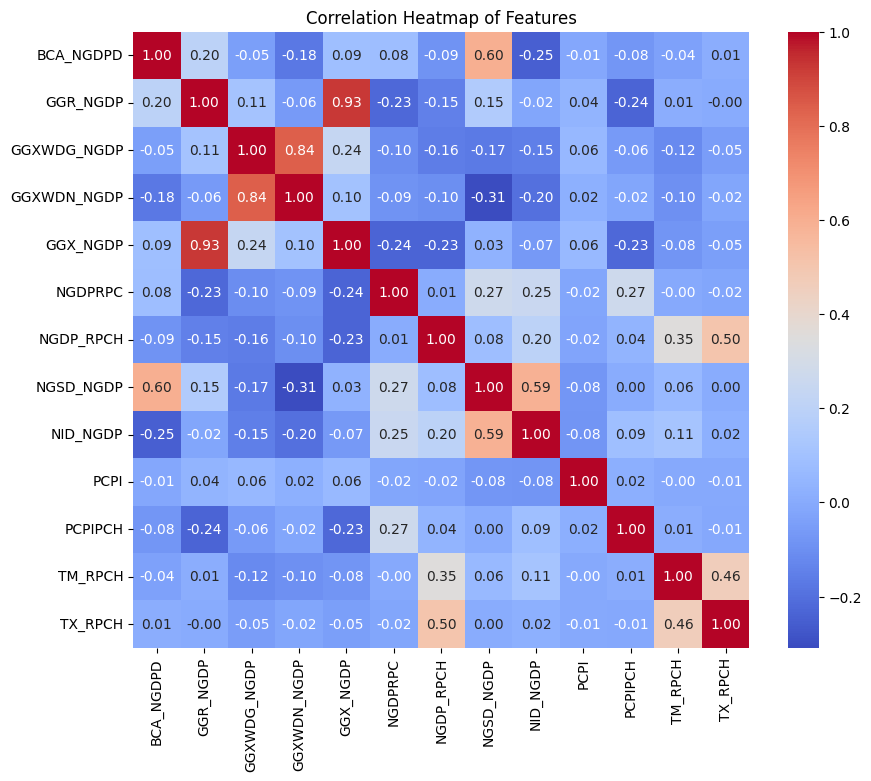

In [12]:
corr = df_filtered.drop(columns=["Country", "Recession"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Features")
plt.show()

## Prepare Features and Target

In [13]:
X = df_filtered.drop(columns=["Recession", "Country"])
y = df_filtered["Recession"]

# 5. Machine Learning Models

## Global Dataset - Full Features (13 Features)

### Define and Train All Models

In [14]:
def train_all_models(X_train, y_train, X_test, y_test, model_params=None, use_xgb=False, threshold=0.5):
    """
    Train multiple models with SMOTE, evaluate them on train/test sets,
    and return metrics including confusion matrices. Threshold can be set
    for probability-based classifiers.
    """

    # Default hyperparameters
    if model_params is None:
        model_params = {
            'logit': {'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs',
                      'max_iter': 5000, 'random_state': 42},
            'rf': {'n_estimators': 200, 'max_depth': 4,
                   'min_samples_leaf': 20, 'min_samples_split': 20,
                   'max_features': 0.3, 'random_state': 42},
            'gb': {'n_estimators': 200, 'learning_rate': 0.03,
                   'max_depth': 2, 'min_samples_leaf': 20,
                   'subsample': 0.6, 'random_state': 42},
            'dt': {'max_depth': 3, 'min_samples_leaf': 30, 'random_state': 42},
            'svm': {'C': 1.0, 'kernel': 'rbf', 'probability': True, 'random_state': 42},
            'xgb': {'n_estimators': 200, 'learning_rate': 0.05,
                    'max_depth': 2, 'subsample': 0.7, 'colsample_bytree': 0.6,
                    'reg_alpha': 0.4, 'reg_lambda': 2.0, 'random_state': 42,
                    'use_label_encoder': False, 'eval_metric': 'logloss'}
        }

    # Train models -----------------------------------------------------
    logit = ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("logit", LogisticRegression(**model_params['logit']))
    ]).fit(X_train, y_train)

    rf = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("rf", RandomForestClassifier(**model_params['rf']))
    ]).fit(X_train, y_train)

    gb = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("gb", GradientBoostingClassifier(**model_params['gb']))
    ]).fit(X_train, y_train)

    dt = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("dt", DecisionTreeClassifier(**model_params['dt']))
    ]).fit(X_train, y_train)

    svm = ImbPipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("svm", SVC(**model_params['svm']))
    ]).fit(X_train, y_train)

    models = {
        "Logistic Regression": logit,
        "Random Forest": rf,
        "Gradient Boosting": gb,
        "Decision Tree": dt,
        "SVM": svm,
    }

    # XGBoost optional
    if use_xgb:
        xgb = ImbPipeline([
            ("smote", SMOTE(random_state=42)),
            ("xgb", XGBClassifier(**model_params['xgb']))
        ]).fit(X_train, y_train)
        models["XGBoost"] = xgb

    # Ensemble (soft voting only)
    ensemble_estimators = [
        ("logit", logit.named_steps["logit"]),
        ("rf", rf.named_steps["rf"]),
        ("gb", gb.named_steps["gb"]),
        ("svm", svm.named_steps["svm"])
    ]
    if use_xgb:
        ensemble_estimators.append(("xgb", xgb.named_steps["xgb"]))

    ensemble = VotingClassifier(estimators=ensemble_estimators, voting="soft")
    ensemble.fit(X_train, y_train)
    models["Ensemble"] = ensemble

    # Compute metrics -----------------------------------------------------------
    results = {}
    confusion_mats = {}

    for name, m in models.items():
        if hasattr(m, "predict_proba"):
            y_pred_train = (m.predict_proba(X_train)[:, 1] >= threshold).astype(int)
            y_pred_test = (m.predict_proba(X_test)[:, 1] >= threshold).astype(int)
        else:
            y_pred_train = m.predict(X_train)
            y_pred_test = m.predict(X_test)

        results[name] = {
            "Train Accuracy": accuracy_score(y_train, y_pred_train),
            "Test Accuracy": accuracy_score(y_test, y_pred_test),
            "Precision": precision_score(y_test, y_pred_test, zero_division=0),
            "Recall": recall_score(y_test, y_pred_test, zero_division=0),
            "F1": f1_score(y_test, y_pred_test, zero_division=0)
        }

        confusion_mats[name] = confusion_matrix(y_test, y_pred_test)

    results_df = pd.DataFrame(results).T
    return models, results_df, confusion_mats



# ============================================================
#             FEATURE IMPORTANCE PLOTTING
# ============================================================
def plot_feature_importance(models, feature_names, title_prefix=""):
    logit = models.get("Logistic Regression")
    rf = models.get("Random Forest")
    gb = models.get("Gradient Boosting")
    dt = models.get("Decision Tree")

    coef = logit.named_steps['logit'].coef_[0]
    logit_importance = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coef,
        "Abs_Importance": np.abs(coef)
    }).sort_values("Abs_Importance")

    rf_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": rf.named_steps['rf'].feature_importances_
    }).sort_values("Importance")

    gb_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": gb.named_steps['gb'].feature_importances_
    }).sort_values("Importance")

    dt_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": dt.named_steps['dt'].feature_importances_
    }).sort_values("Importance")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes[0, 0].barh(logit_importance["Feature"], logit_importance["Coefficient"])
    axes[0, 0].set_title(f"{title_prefix}Logistic Regression")

    axes[0, 1].barh(rf_importance["Feature"], rf_importance["Importance"])
    axes[0, 1].set_title(f"{title_prefix}Random Forest")

    axes[1, 0].barh(gb_importance["Feature"], gb_importance["Importance"])
    axes[1, 0].set_title(f"{title_prefix}Gradient Boosting")

    axes[1, 1].barh(dt_importance["Feature"], dt_importance["Importance"])
    axes[1, 1].set_title(f"{title_prefix}Decision Tree")

    plt.tight_layout()
    plt.show()


# ============================================================
#                  PREDICTION FUNCTION
# ============================================================
def make_predictions(models, df_predict, use_threshold=True, threshold=0.20):
    """
    Return predictions from every model in one dataframe.
    """
    predictions = {}
    for name, model in models.items():
        if use_threshold and hasattr(model, 'predict_proba'):
            proba = model.predict_proba(df_predict)[:, 1]
            predictions[name] = (proba >= threshold).astype(int)
        else:
            predictions[name] = model.predict(df_predict)
    return pd.DataFrame(predictions, index=df_predict.index)


# ============================================================
#             CONFUSION MATRIX DISPLAY FUNCTION (with metrics incl. Accuracy)
# ============================================================
def show_confusion_matrices(confusion_mats, results_df, threshold=0.5):
    """
    Display confusion matrices for all models side by side,
    with Accuracy, Precision, Recall, and F1 shown under each matrix.
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay

    n_models = len(confusion_mats)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))

    if n_models == 1:
        axes = [axes]

    for ax, (name, cm) in zip(axes, confusion_mats.items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", ax=ax, colorbar=False)

        # Extract metrics from results_df
        accuracy = results_df.loc[name, "Test Accuracy"]
        precision = results_df.loc[name, "Precision"]
        recall = results_df.loc[name, "Recall"]
        f1 = results_df.loc[name, "F1"]
    from sklearn.metrics import ConfusionMatrixDisplay

    n_models = len(confusion_mats)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))

    if n_models == 1:
        axes = [axes]

    for ax, (name, cm) in zip(axes, confusion_mats.items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

### Train-Test Split

In [15]:
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

                     Train Accuracy  Test Accuracy  Precision    Recall  \
Logistic Regression        0.748160       0.728992   0.731518  0.758065   
Random Forest              0.816509       0.794118   0.828947  0.762097   
Gradient Boosting          0.829127       0.789916   0.836364  0.741935   
Decision Tree              0.800210       0.775210   0.837321  0.705645   
SVM                        0.832808       0.768908   0.773810  0.786290   
Ensemble                   0.828601       0.800420   0.958084  0.645161   

                           F1  
Logistic Regression  0.744554  
Random Forest        0.794118  
Gradient Boosting    0.786325  
Decision Tree        0.765864  
SVM                  0.780000  
Ensemble             0.771084  
[[221   7]
 [ 88 160]]


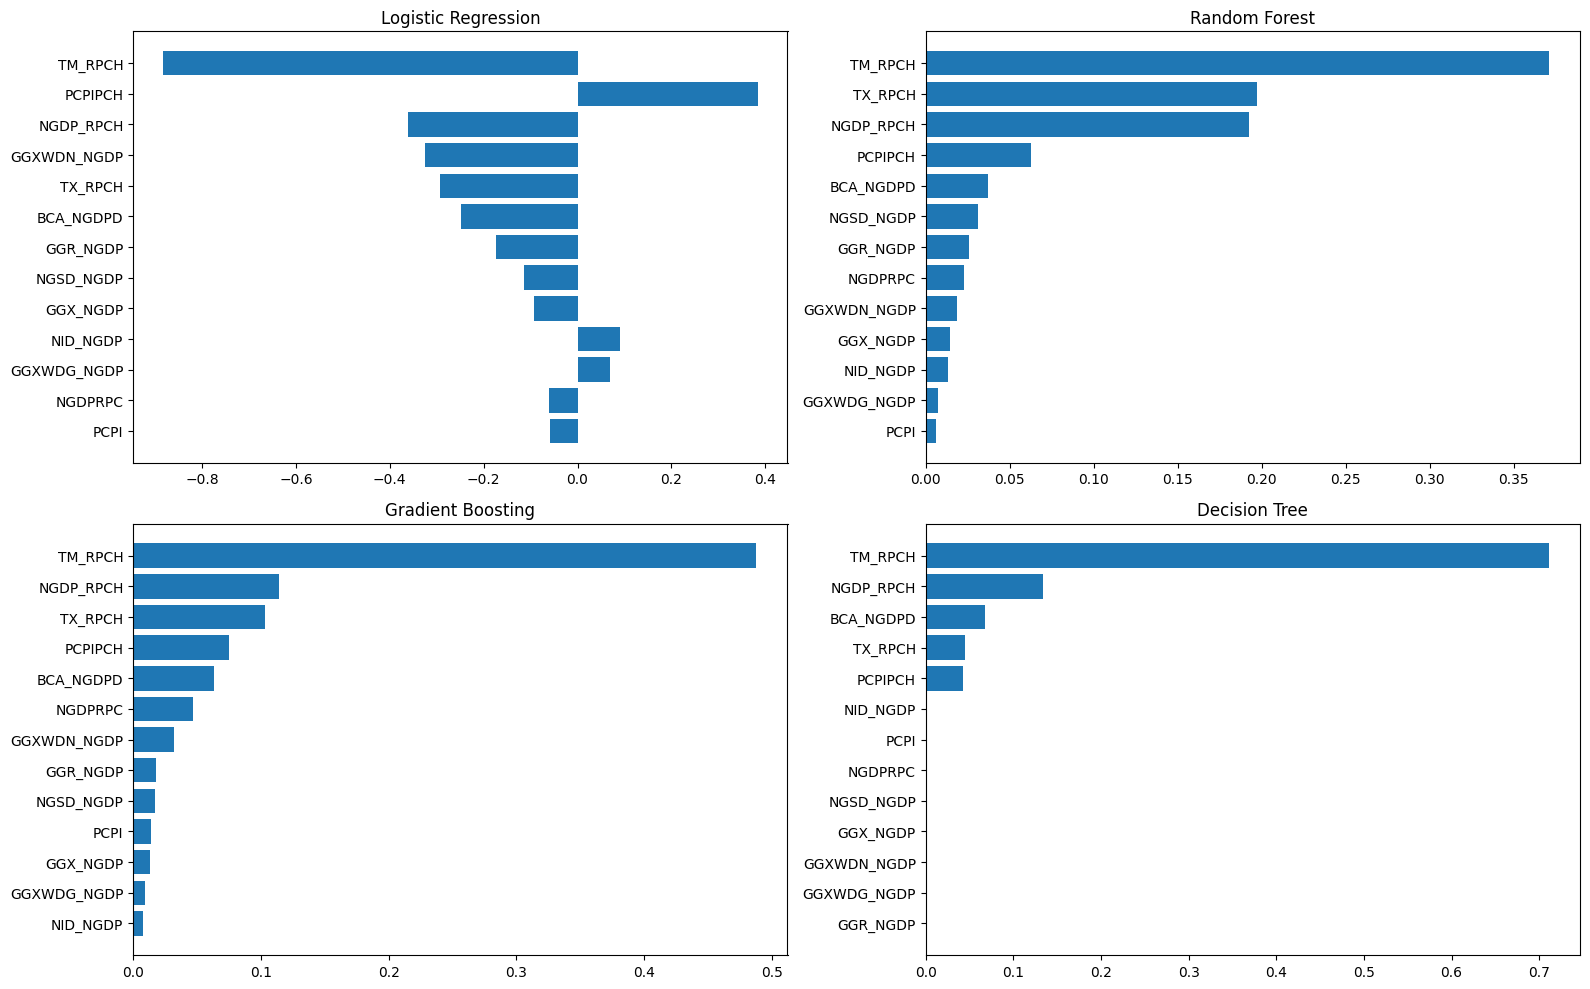

      Logistic Regression  Random Forest  Gradient Boosting  Decision Tree  \
Year                                                                         
2025                    1              1                  1              1   
2025                    1              1                  1              1   
2025                    1              1                  0              1   
2025                    1              1                  0              1   
2025                    1              1                  1              1   

      SVM  Ensemble  
Year                 
2025    1         1  
2025    1         1  
2025    1         1  
2025    1         1  
2025    1         1  


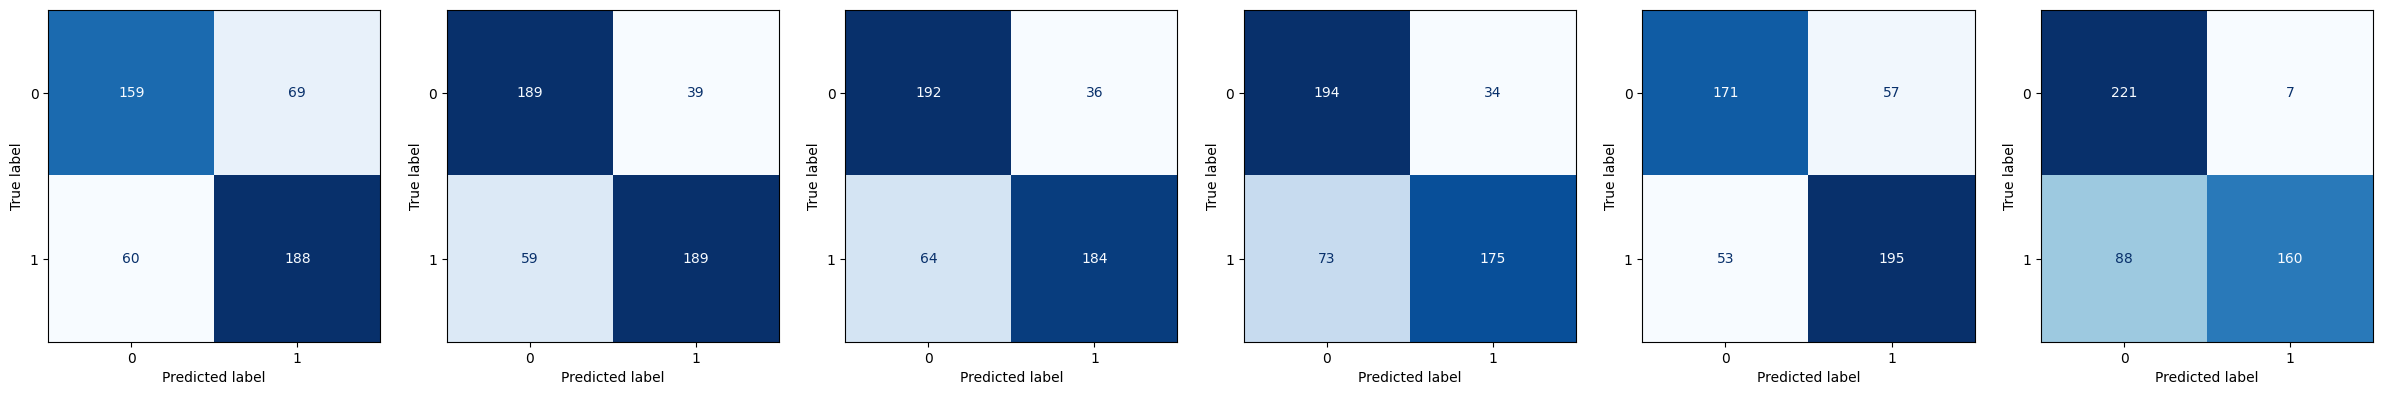

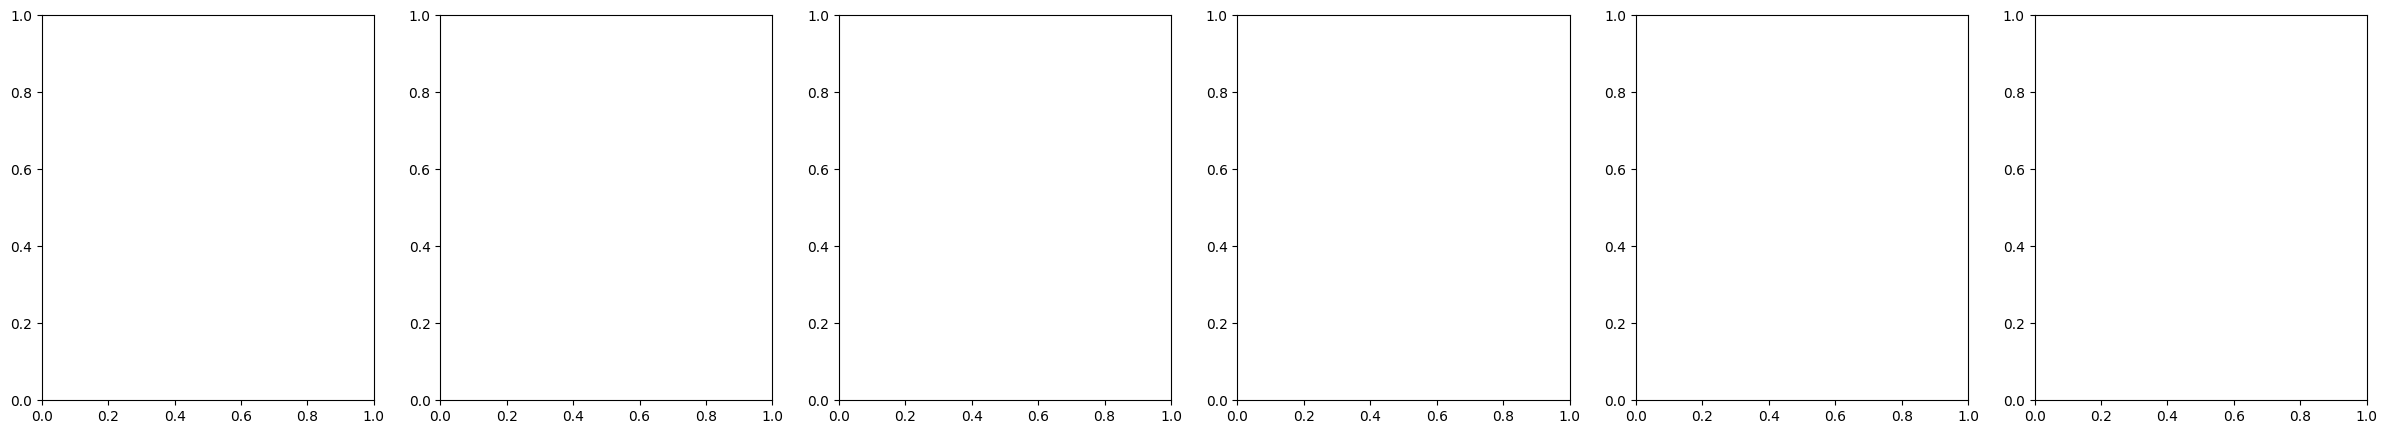

In [16]:
models, summary_df, confusion_mats = train_all_models(X_train, y_train, X_test, y_test)
print(summary_df)
print(confusion_mats["Ensemble"])  # example: confusion matrix for ensemble

plot_feature_importance(models, X_train.columns.tolist())

predictions = make_predictions(models, df_predict)
print(predictions.head())

# Show confusion matrices with metrics underneath
show_confusion_matrices(confusion_mats, summary_df, threshold=0.5)

### Reduced Global Set

In [17]:
selected_features = ['TM_RPCH', 'NGDP_RPCH', 'TX_RPCH', 'PCPIPCH', 'BCA_NGDPD']
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

# Unpack all three return values
models_reduced, summary_df_reduced, confusion_mats_reduced = train_all_models(
    X_train_reduced, y_train, X_test_reduced, y_test, threshold=0.5
)

# Show metrics table
print(summary_df_reduced)


                     Train Accuracy  Test Accuracy  Precision    Recall  \
Logistic Regression        0.743954       0.703782   0.704981  0.741935   
Random Forest              0.808097       0.789916   0.830357  0.750000   
Gradient Boosting          0.807571       0.787815   0.815451  0.766129   
Decision Tree              0.808623       0.777311   0.869792  0.673387   
SVM                        0.809148       0.762605   0.760618  0.794355   
Ensemble                   0.818612       0.802521   0.909574  0.689516   

                           F1  
Logistic Regression  0.722986  
Random Forest        0.788136  
Gradient Boosting    0.790021  
Decision Tree        0.759091  
SVM                  0.777120  
Ensemble             0.784404  


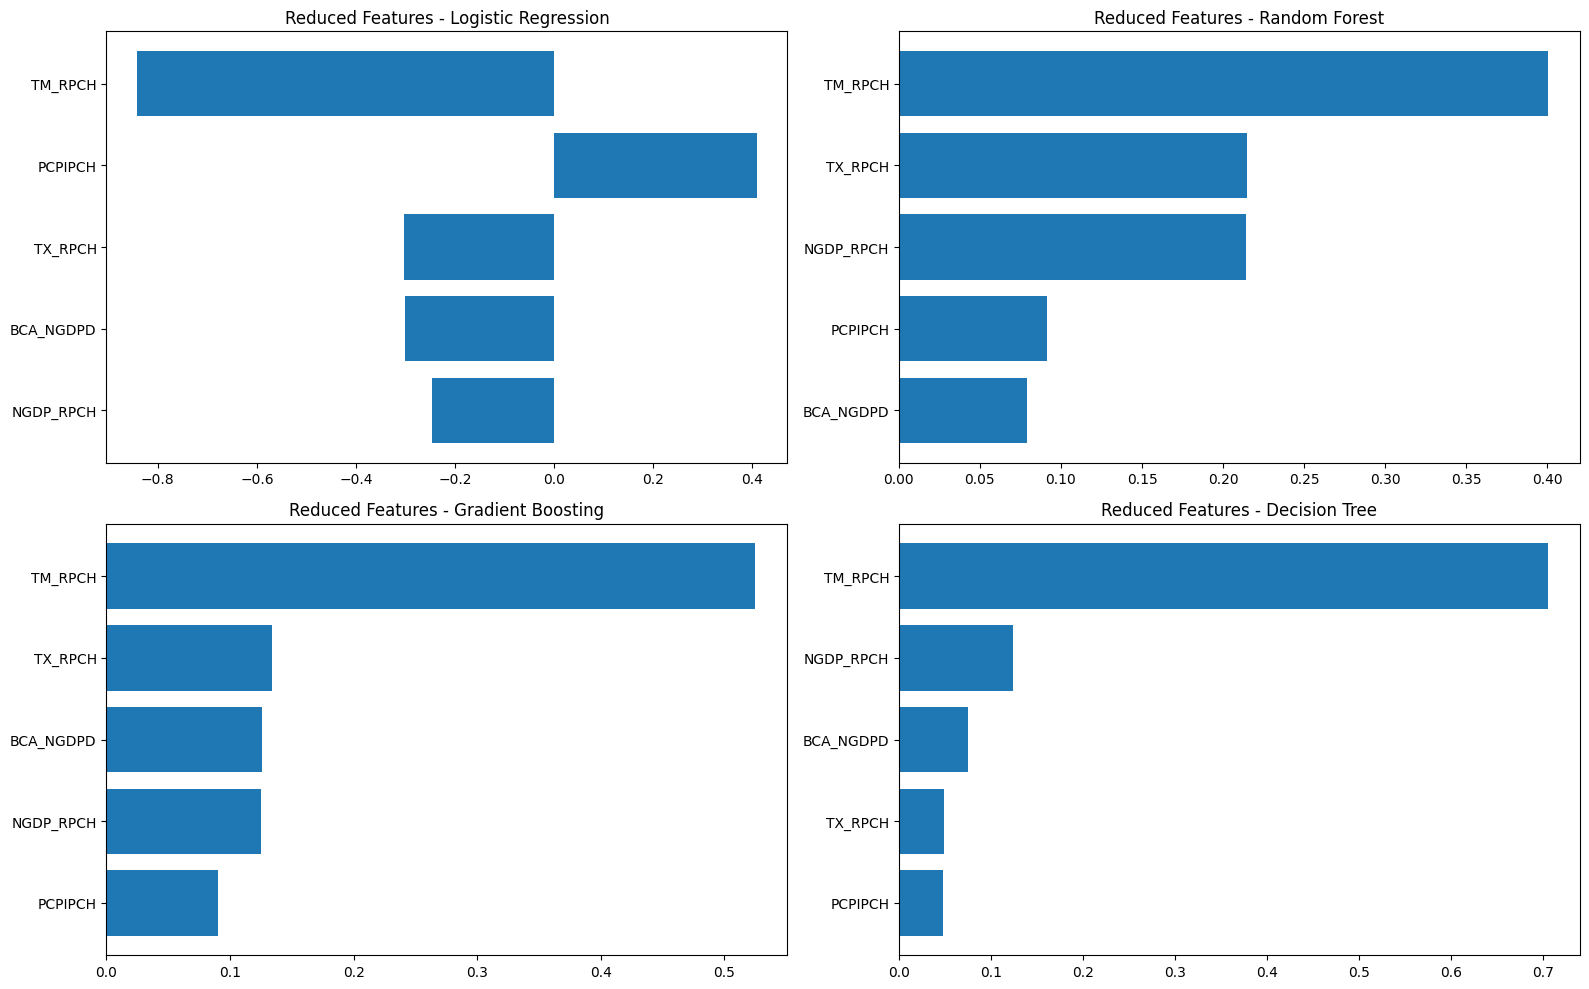

In [18]:
# Plot feature importance
plot_feature_importance(models_reduced, feature_names=selected_features, title_prefix="Reduced Features - ")


In [19]:
# Predictions on restricted df
df_predict_restricted = df_predict[selected_features]
predictions_restricted = make_predictions(models_reduced, df_predict_restricted, threshold=0.5)
print(predictions_restricted)


      Logistic Regression  Random Forest  Gradient Boosting  Decision Tree  \
Year                                                                         
2025                    1              0                  0              0   
2025                    0              0                  0              0   
2025                    0              0                  0              0   
2025                    1              0                  0              0   
2025                    1              1                  1              1   
...                   ...            ...                ...            ...   
2030                    1              0                  0              0   
2030                    0              0                  0              0   
2030                    1              0                  0              0   
2030                    0              0                  0              0   
2030                    0              0                  0     

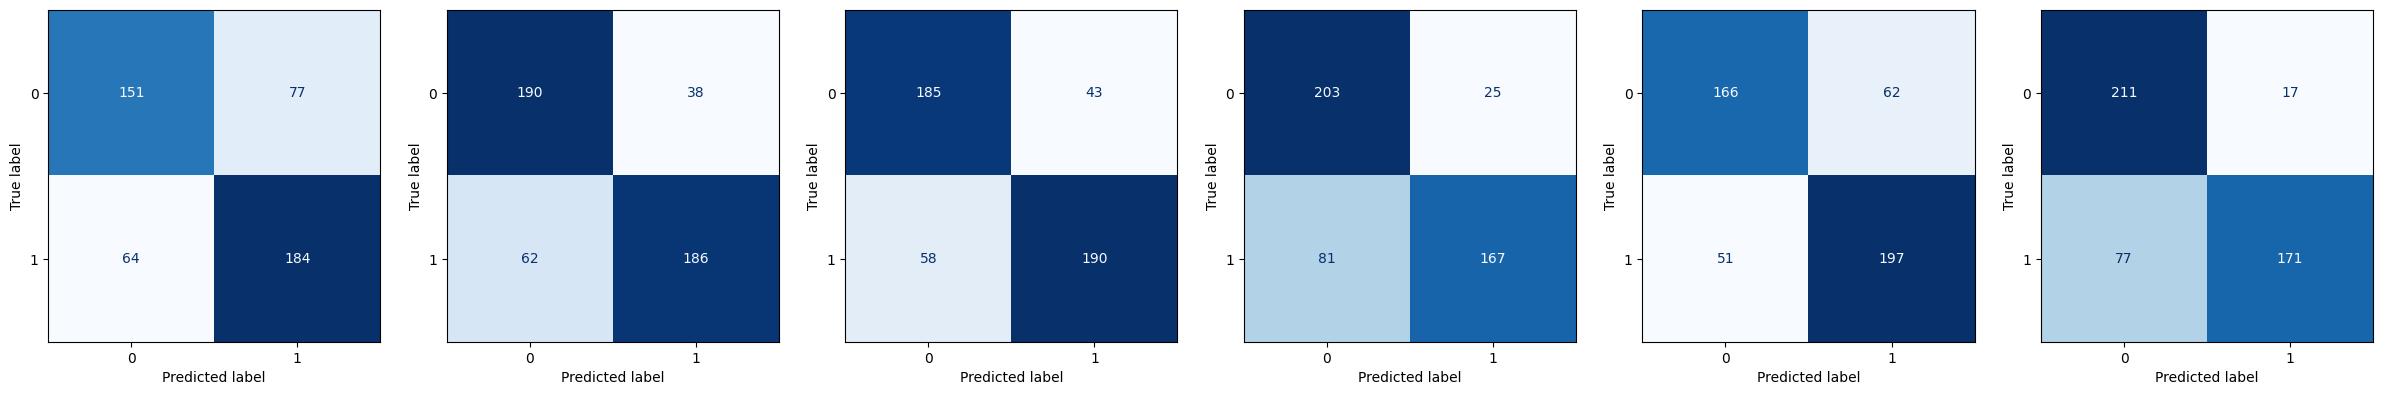

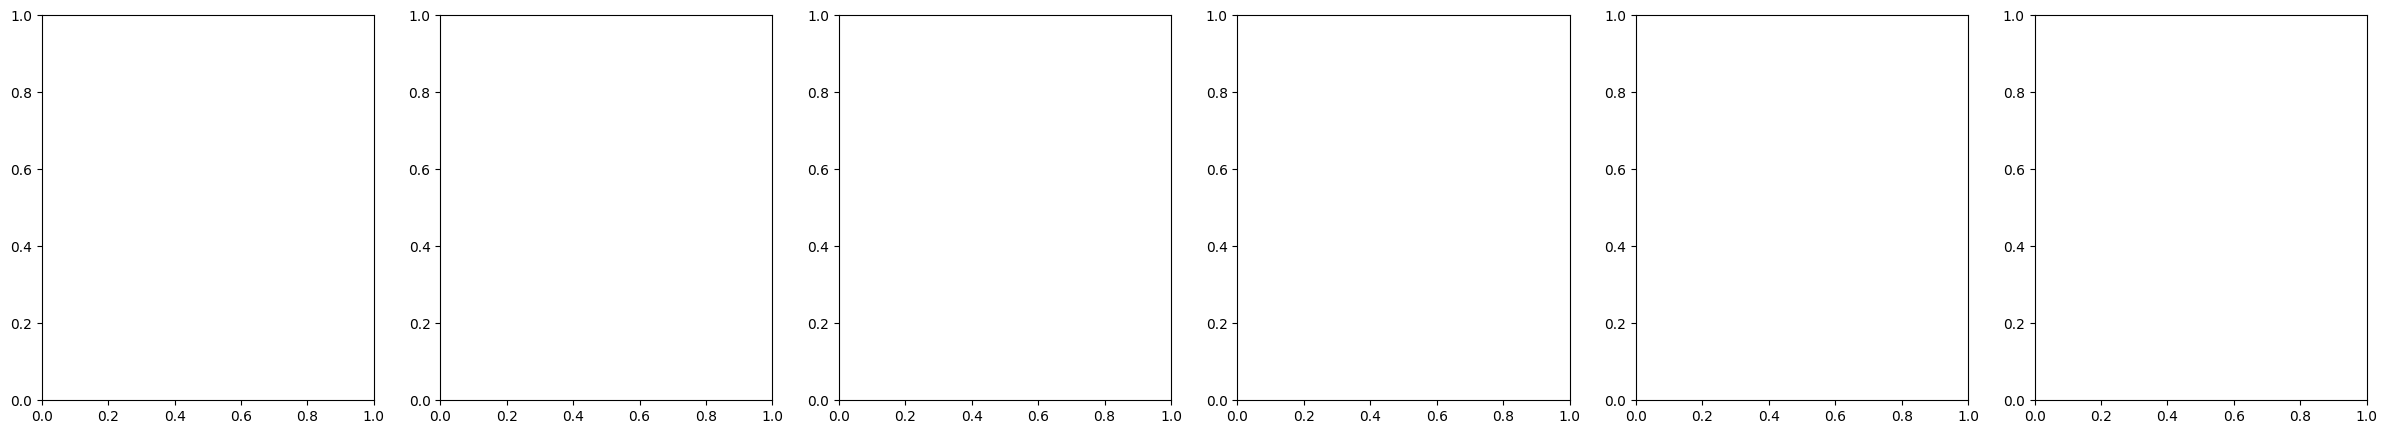

In [20]:

# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_reduced, summary_df_reduced, threshold=0.5)

### Split Dataset

In [21]:
# Map countries to continents (same logic as before)
try:
    import pycountry
    import pycountry_convert as pc
    
    def country_to_continent(name):
        try:
            lookup_name = name.replace('_', ' ')
            country = pycountry.countries.lookup(lookup_name)
            alpha2 = country.alpha_2
            cc = pc.country_alpha2_to_continent_code(alpha2)
            continent_map = {
                'AF': 'Africa',
                'AS': 'Asia',
                'EU': 'Europe',
                'NA': 'North_America',
                'OC': 'Oceania',
                'SA': 'South_America'
            }
            return continent_map.get(cc, 'Unknown')
        except Exception:
            return 'Unknown'
except ImportError:
    # Fallback mapping for common countries (extend as needed)
    fallback = {
        'United_States': 'North_America', 'Canada': 'North_America', 'Mexico': 'North_America',
        'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia', 'Afghanistan': 'Asia',
        'Korea': 'Asia', 'Indonesia': 'Asia', 'Thailand': 'Asia', 'Vietnam': 'Asia',
        'Germany': 'Europe', 'France': 'Europe', 'United_Kingdom': 'Europe', 'Italy': 'Europe',
        'Spain': 'Europe', 'Russia': 'Europe', 'Turkey': 'Europe', 'Poland': 'Europe',
        'Brazil': 'South_America', 'Argentina': 'South_America', 'Chile': 'South_America',
        'Colombia': 'South_America', 'Peru': 'South_America', 'Venezuela': 'South_America',
        'Australia': 'Oceania', 'New_Zealand': 'Oceania',
        'South_Africa': 'Africa', 'Nigeria': 'Africa', 'Egypt': 'Africa', 'Zimbabwe': 'Africa',
        'Kenya': 'Africa', 'Ethiopia': 'Africa', 'Morocco': 'Africa',
        # Additional countries...
        'Albania': 'Europe', 'Algeria': 'Africa', 'Austria': 'Europe', 'Barbados': 'North_America',
        'Belgium': 'Europe', 'Bolivia': 'South_America', 'Bosnia_and_Herzegovina': 'Europe',
        'Bulgaria': 'Europe', 'Cabo_Verde': 'Africa', 'Costa_Rica': 'North_America',
        'Croatia': 'Europe', 'Cyprus': 'Europe', 'Czech_Republic': 'Europe', 'Denmark': 'Europe',
        'Dominican_Republic': 'North_America', 'Estonia': 'Europe', 'Finland': 'Europe',
        'Hungary': 'Europe', 'Iceland': 'Europe', 'Ireland': 'Europe',
        'Islamic_Republic_of_Iran': 'Asia', 'Israel': 'Asia', 'Jordan': 'Asia',
        'Kazakhstan': 'Asia', 'Latvia': 'Europe', 'Lebanon': 'Asia', 'Lithuania': 'Europe',
        'Luxembourg': 'Europe', 'Malta': 'Europe', 'Netherlands': 'Europe',
        'North_Macedonia': 'Europe', 'Norway': 'Europe', 'Pakistan': 'Asia',
        'Panama': 'North_America', 'Paraguay': 'South_America', 'Portugal': 'Europe',
        'Romania': 'Europe', 'Saudi_Arabia': 'Asia', 'Serbia': 'Europe', 'Seychelles': 'Africa',
        'Slovak_Republic': 'Europe', 'Slovenia': 'Europe', 'Sweden': 'Europe',
        'Switzerland': 'Europe', 'Syria': 'Asia', 'Taiwan_Province_of_China': 'Asia',
        'Trinidad_and_Tobago': 'North_America', 'Türkiye': 'Europe', 'Uruguay': 'South_America'
    }
    
    def country_to_continent(name):
        return fallback.get(name.replace(' ', '_'), 'Unknown')

# --- Add Continent column ---
df_filtered_copy = df_pivot.copy()
df_filtered_copy['Continent'] = df_filtered_copy['Country'].astype(str).apply(country_to_continent)

# --- Map continents to economy groups ---
continent_to_economy = {
    'Europe': 'Upper_Economies',
    'North_America': 'Upper_Economies',
    'Oceania': 'Upper_Economies',
    'Africa': 'Lower_Economies',
    'Asia': 'Lower_Economies',
    'South_America': 'Lower_Economies'
}

df_filtered_copy['EconomyGroup'] = df_filtered_copy['Continent'].map(continent_to_economy)

# --- Create Lower and Upper economy DataFrames ---
df_Lower_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Lower_Economies'].drop(columns=['Continent','EconomyGroup'])
df_Upper_Economies = df_filtered_copy[df_filtered_copy['EconomyGroup'] == 'Upper_Economies'].drop(columns=['Continent','EconomyGroup'])

# --- Print summary ---
print("Created economy-specific DataFrames:")
print(f" - Lower_Economies: df_Lower_Economies (rows: {len(df_Lower_Economies)})")
print(f" - Upper_Economies: df_Upper_Economies (rows: {len(df_Upper_Economies)})")


Created economy-specific DataFrames:
 - Lower_Economies: df_Lower_Economies (rows: 863)
 - Upper_Economies: df_Upper_Economies (rows: 1553)


In [22]:
df_Lower_Economies

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Recession
Year,,,,,,,,,,,,,,,
1980,Japan,-0.952,26.324,47.776,17.424,30.739,2.341283e+06,3.181,29.655,35.188,73.144,7.808,-7.761,16.983,0
1981,Japan,0.382,27.657,52.815,21.082,31.509,2.423319e+06,4.261,30.161,34.011,76.755,4.936,2.136,13.320,0
1982,Japan,0.591,27.918,57.730,25.384,31.731,2.485303e+06,3.280,29.086,32.854,78.865,2.749,-0.674,1.432,1
1983,Japan,1.637,27.893,63.511,30.049,31.839,2.557824e+06,3.630,28.231,31.461,80.348,1.880,-3.443,4.972,0
1984,Japan,2.601,28.576,65.602,32.449,31.200,2.653309e+06,4.411,29.118,31.323,82.156,2.251,10.537,15.320,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,Paraguay,-1.163,19.295,39.385,37.059,20.810,3.933554e+07,3.500,20.677,21.840,164.000,3.500,2.588,2.912,0
2030,Peru,-1.463,20.062,35.957,26.375,21.038,1.882146e+04,2.496,18.336,19.799,127.554,2.000,3.338,1.945,0
2030,Saudi_Arabia,-3.431,26.860,45.915,36.056,29.948,1.075253e+05,3.282,29.059,32.491,125.334,2.000,3.358,3.316,0


In [23]:
df_Upper_Economies

,Country,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Recession
Year,,,,,,,,,,,,,,,
1980,Finland,-2.612,46.745,10.893,62.466,43.864,21732.461,5.673,28.775,31.224,32.979,11.602,8.552,8.098,0
1980,United_Kingdom,0.694,36.203,42.517,41.821,39.039,18811.646,-2.050,19.808,19.114,31.268,16.849,-3.557,-0.513,1
1980,Norway,1.674,49.022,47.683,0.111,43.883,529775.630,4.515,28.541,28.534,31.174,10.912,2.926,4.677,0
1980,Canada,-2.205,36.903,44.590,14.481,40.946,36526.988,2.163,20.202,22.386,44.037,10.183,-3.171,0.953,0
1981,Canada,-4.180,38.940,46.077,13.569,41.832,37327.825,3.503,21.113,25.296,49.525,12.462,2.554,1.776,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,Slovak_Republic,-1.556,41.028,77.426,72.588,47.158,21855.878,2.060,20.665,22.221,165.494,1.978,3.093,3.228,0
2030,Slovenia,2.490,44.602,63.768,48.605,47.129,25669.082,2.300,24.812,22.138,145.426,2.096,3.784,3.581,0
2030,Spain,1.252,42.492,92.970,83.672,44.523,29018.468,1.623,22.191,20.939,139.260,2.000,3.489,3.385,0


## Split Dataset of prediction

In [24]:
df_predict_original['Continent'] = df_predict_original['Country'].astype(str).apply(country_to_continent)

continent_to_economy = {
    'Europe': 'Upper_Economies',
    'North_America': 'Upper_Economies',
    'Oceania': 'Upper_Economies',
    'Africa': 'Lower_Economies',
    'Asia': 'Lower_Economies',
    'South_America': 'Lower_Economies'
}

df_predict_original['EconomyGroup'] = df_predict_original['Continent'].map(continent_to_economy)

df_predict_lower = df_predict_original[df_predict_original['EconomyGroup'] == 'Lower_Economies'].drop(
    columns=['Continent', 'EconomyGroup', 'Country']
)
df_predict_upper = df_predict_original[df_predict_original['EconomyGroup'] == 'Upper_Economies'].drop(
    columns=['Continent', 'EconomyGroup', 'Country']
)

print("Created economy-specific prediction DataFrames from df_predict_original:")
print(f" - Lower_Economies predictions: {len(df_predict_lower)} rows")
print(f" - Upper_Economies predictions: {len(df_predict_upper)} rows")

df_predict_lower.head()
df_predict_upper.head()

Created economy-specific prediction DataFrames from df_predict_original:
 - Lower_Economies predictions: 152 rows
 - Upper_Economies predictions: 258 rows


,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGXWDN_NGDP,GGX_NGDP,NGDPRPC,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPI,PCPIPCH,TM_RPCH,TX_RPCH,Recession
Year,,,,,,,,,,,,,,
2025,5.041,32.383,36.897,16.430,32.118,87240.920,0.876,30.592,25.551,107.465,0.229,3.497,2.940,0
2025,2.419,42.370,100.571,89.542,45.059,27928.021,2.501,23.568,21.148,126.061,2.217,2.939,1.888,0
2025,-1.780,15.122,59.661,58.611,18.348,8232076.276,3.443,13.844,15.586,111.861,2.160,4.827,4.578,0
2025,-0.075,40.688,44.219,29.535,43.252,587307.460,1.620,25.293,25.368,155.181,2.481,1.857,0.859,1
2025,-3.684,39.456,103.894,95.050,43.878,37098.556,1.077,13.295,16.979,138.037,3.125,1.830,-0.416,0


# 6. Economy-Specific Analysis

## Upper Economies - Full Features

                     Train Accuracy  Test Accuracy  Precision    Recall  \
Logistic Regression        0.799517       0.652733   0.184000  0.793103   
Random Forest              0.854267       0.900322   0.475000  0.655172   
Gradient Boosting          0.859098       0.877814   0.404255  0.655172   
Decision Tree              0.854267       0.932476   0.681818  0.517241   
SVM                        0.862319       0.704180   0.194175  0.689655   
Ensemble                   0.859903       0.938907   0.750000  0.517241   

                           F1  
Logistic Regression  0.298701  
Random Forest        0.550725  
Gradient Boosting    0.500000  
Decision Tree        0.588235  
SVM                  0.303030  
Ensemble             0.612245  


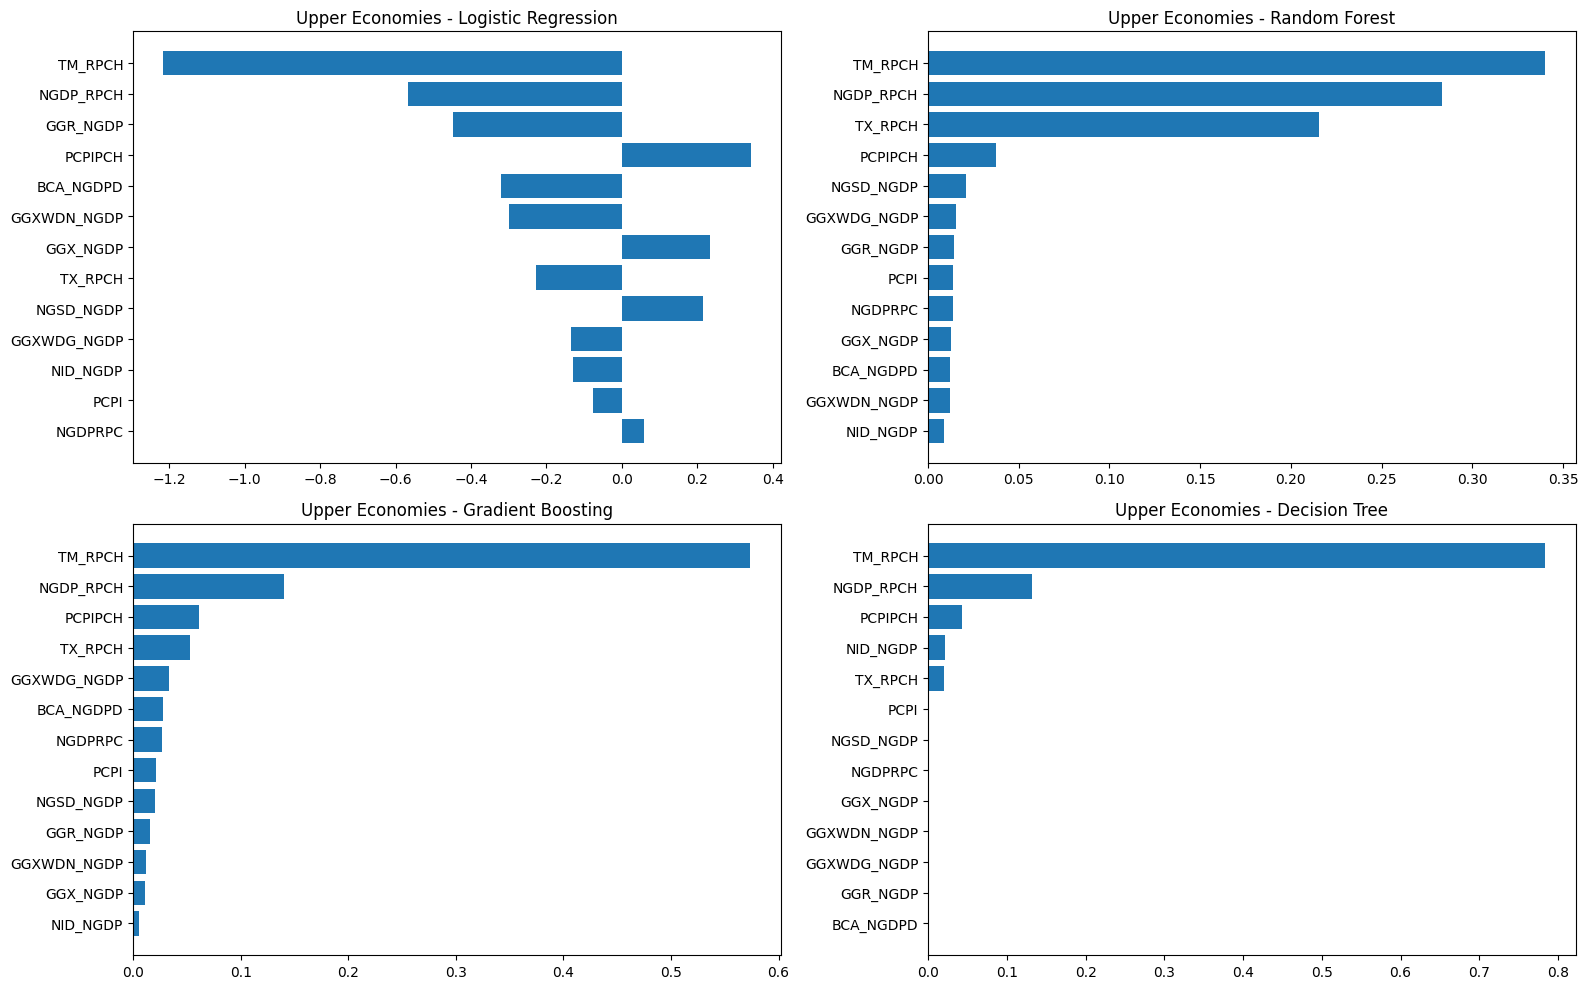

      Logistic Regression  Random Forest  Gradient Boosting  Decision Tree  \
Year                                                                         
2025                    1              0                  0              0   
2025                    0              0                  0              0   
2025                    1              0                  0              0   
2025                    1              0                  0              0   
2025                    0              1                  1              0   
...                   ...            ...                ...            ...   
2030                    0              0                  0              0   
2030                    0              0                  0              0   
2030                    0              0                  0              0   
2030                    1              0                  0              0   
2030                    1              0                  0     

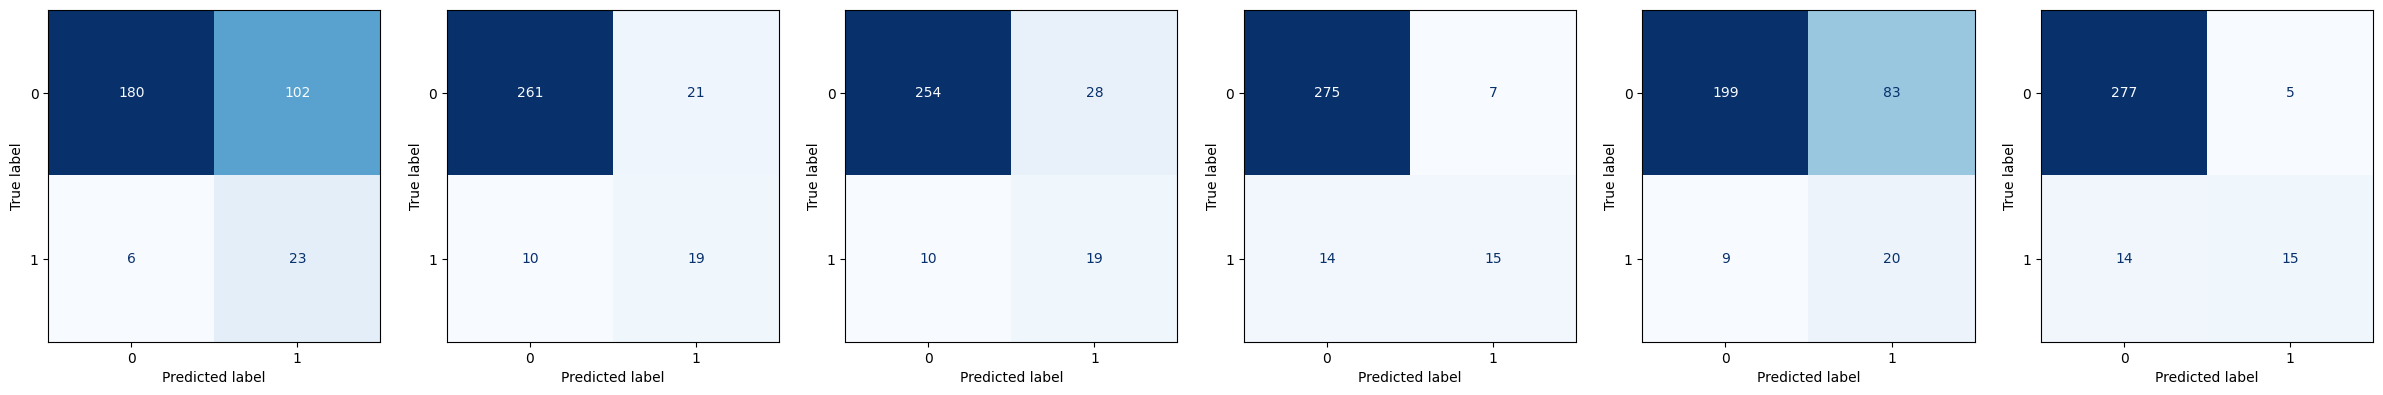

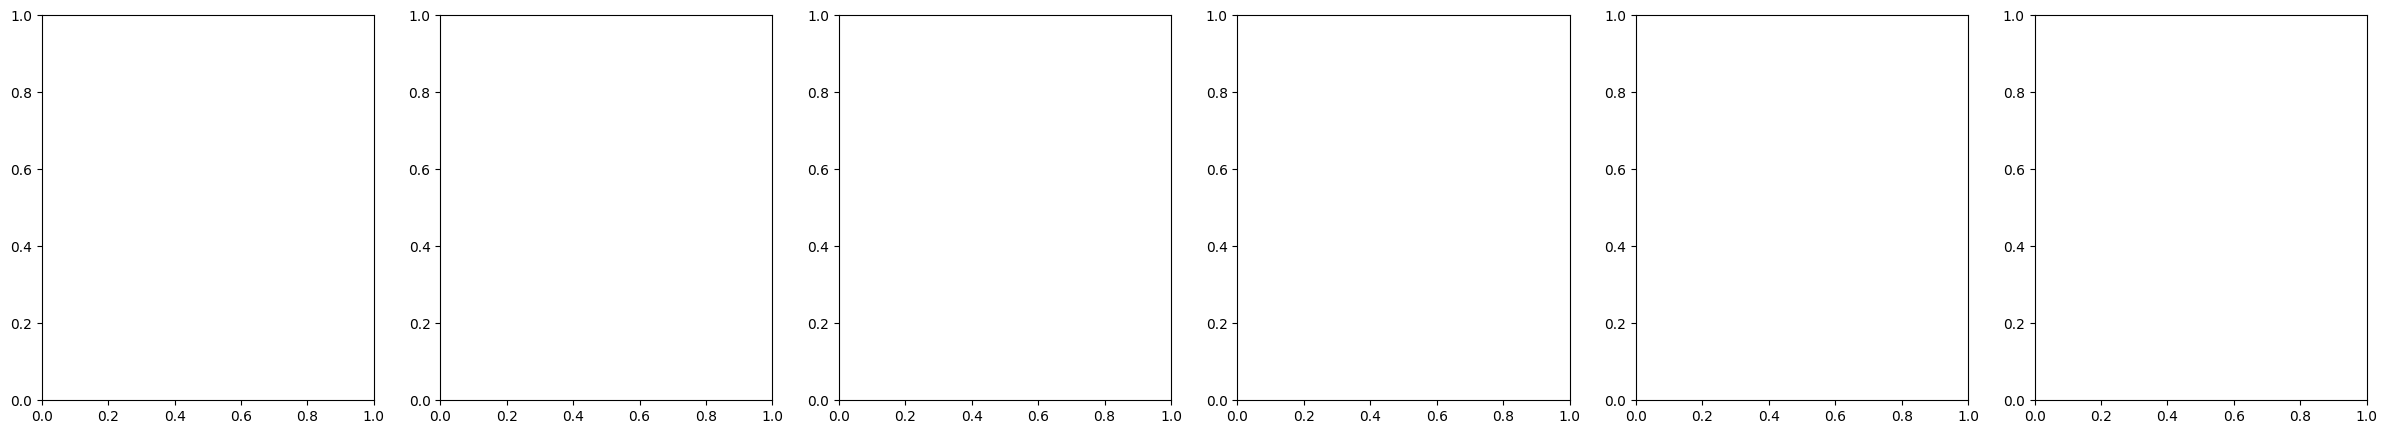

In [25]:
# Prepare data
X = df_Upper_Economies.drop(columns=["Recession", "Country"])
y = df_Upper_Economies["Recession"]

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train models and unpack all three return values
models_upper, summary_df_upper, confusion_mats_upper = train_all_models(
    X_train, y_train, X_test, y_test, threshold=0.5
)

# Show metrics table
print(summary_df_upper)

# Plot feature importance
plot_feature_importance(models_upper, X_train.columns.tolist(), title_prefix="Upper Economies - ")

# Predictions on restricted df
X_predict_upper = df_predict_upper.drop(columns=["Recession", "Country"], errors='ignore')
predictions_upper = make_predictions(models_upper, X_predict_upper, threshold=0.5)
print(predictions_upper)

# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_upper, summary_df_upper, threshold=0.5)


## Lower Economies - Full Features

                     Train Accuracy  Test Accuracy  Precision    Recall  \
Logistic Regression        0.739130       0.606936   0.162500  0.928571   
Random Forest              0.815942       0.901734   0.428571  0.642857   
Gradient Boosting          0.833333       0.843931   0.314286  0.785714   
Decision Tree              0.786957       0.815029   0.235294  0.571429   
SVM                        0.834783       0.763006   0.235294  0.857143   
Ensemble                   0.844928       0.953757   0.800000  0.571429   

                           F1  
Logistic Regression  0.276596  
Random Forest        0.514286  
Gradient Boosting    0.448980  
Decision Tree        0.333333  
SVM                  0.369231  
Ensemble             0.666667  


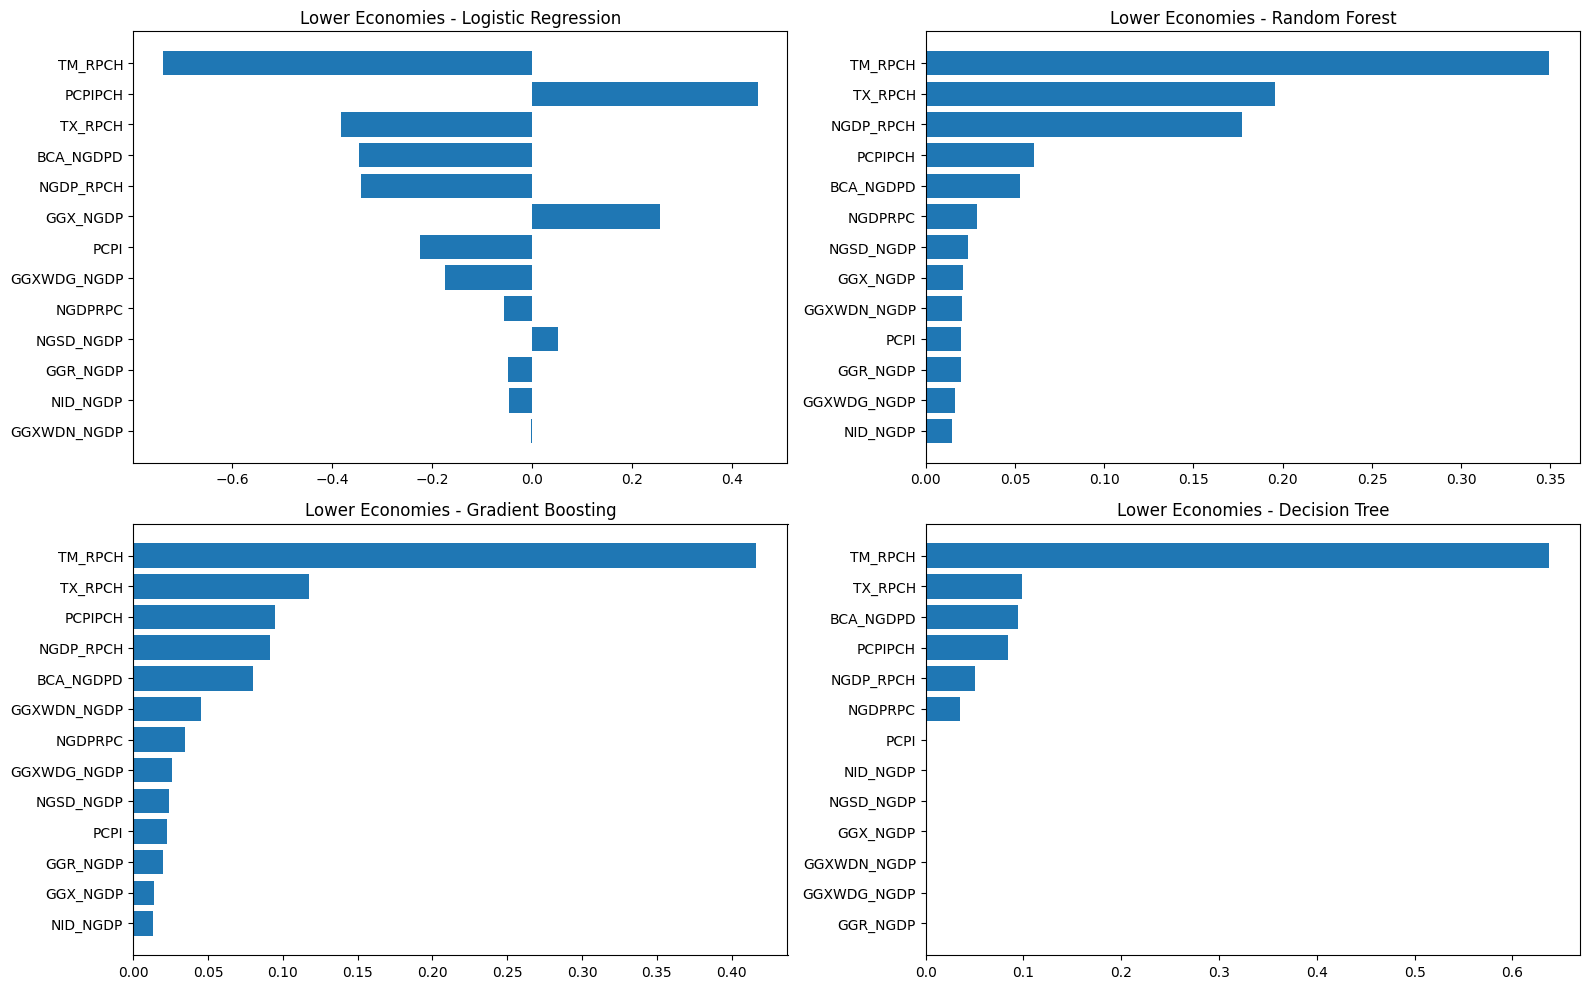

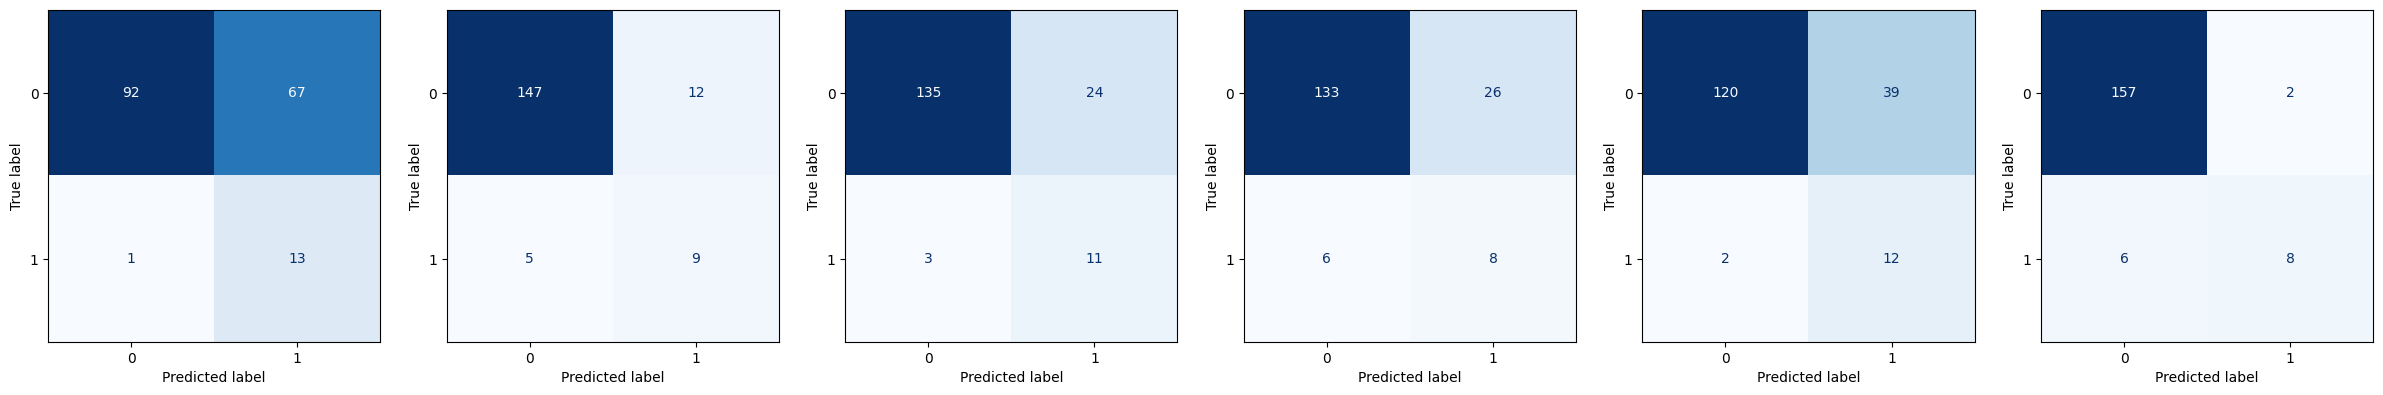

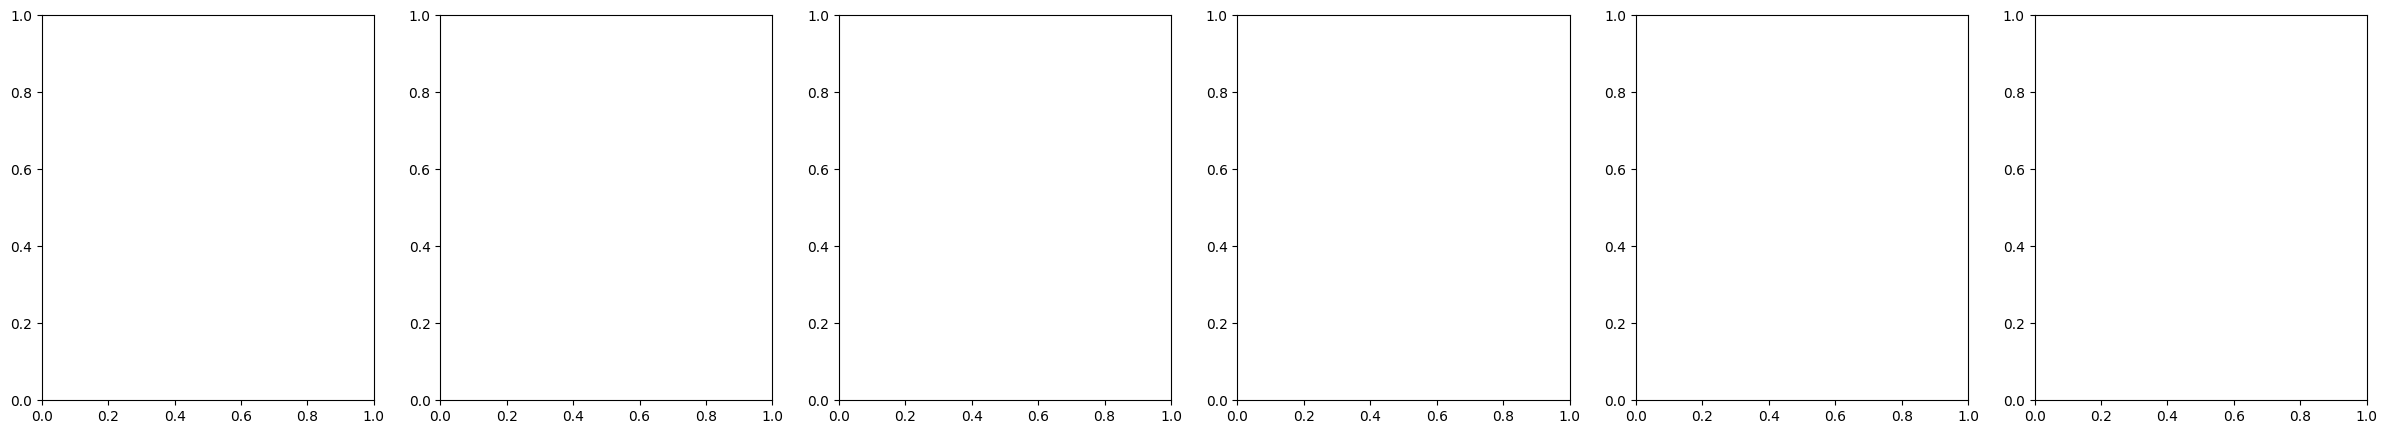

In [26]:
# Prepare data for Lower Economies
X = df_Lower_Economies.drop(columns=["Recession", "Country"])
y = df_Lower_Economies["Recession"]

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train models and unpack all three return values
models_lower, summary_df_lower, confusion_mats_lower = train_all_models(
    X_train, y_train, X_test, y_test, threshold=0.5
)

# Show metrics table
print(summary_df_lower)

# Plot feature importance
plot_feature_importance(models_lower, X_train.columns.tolist(), title_prefix="Lower Economies - ")

# Predictions on restricted df
X_predict_lower = df_predict_lower.drop(columns=["Recession", "Country"], errors='ignore')
predictions_lower = make_predictions(models_lower, X_predict_lower, threshold=0.5)
predictions_lower.head()

# Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_lower, summary_df_lower, threshold=0.5)


## Upper Economies - Reduced Features

Upper Economies Accuracy (Reduced Features):
                     Train Accuracy  Test Accuracy  Precision    Recall  \
Logistic Regression        0.785829       0.565916   0.146667  0.758621   
Random Forest              0.855072       0.916399   0.542857  0.655172   
Gradient Boosting          0.855878       0.900322   0.475000  0.655172   
Decision Tree              0.842995       0.906752   0.500000  0.620690   
SVM                        0.848631       0.816720   0.310811  0.793103   
Ensemble                   0.859903       0.935691   0.666667  0.620690   

                           F1  
Logistic Regression  0.245810  
Random Forest        0.593750  
Gradient Boosting    0.550725  
Decision Tree        0.553846  
SVM                  0.446602  
Ensemble             0.642857  


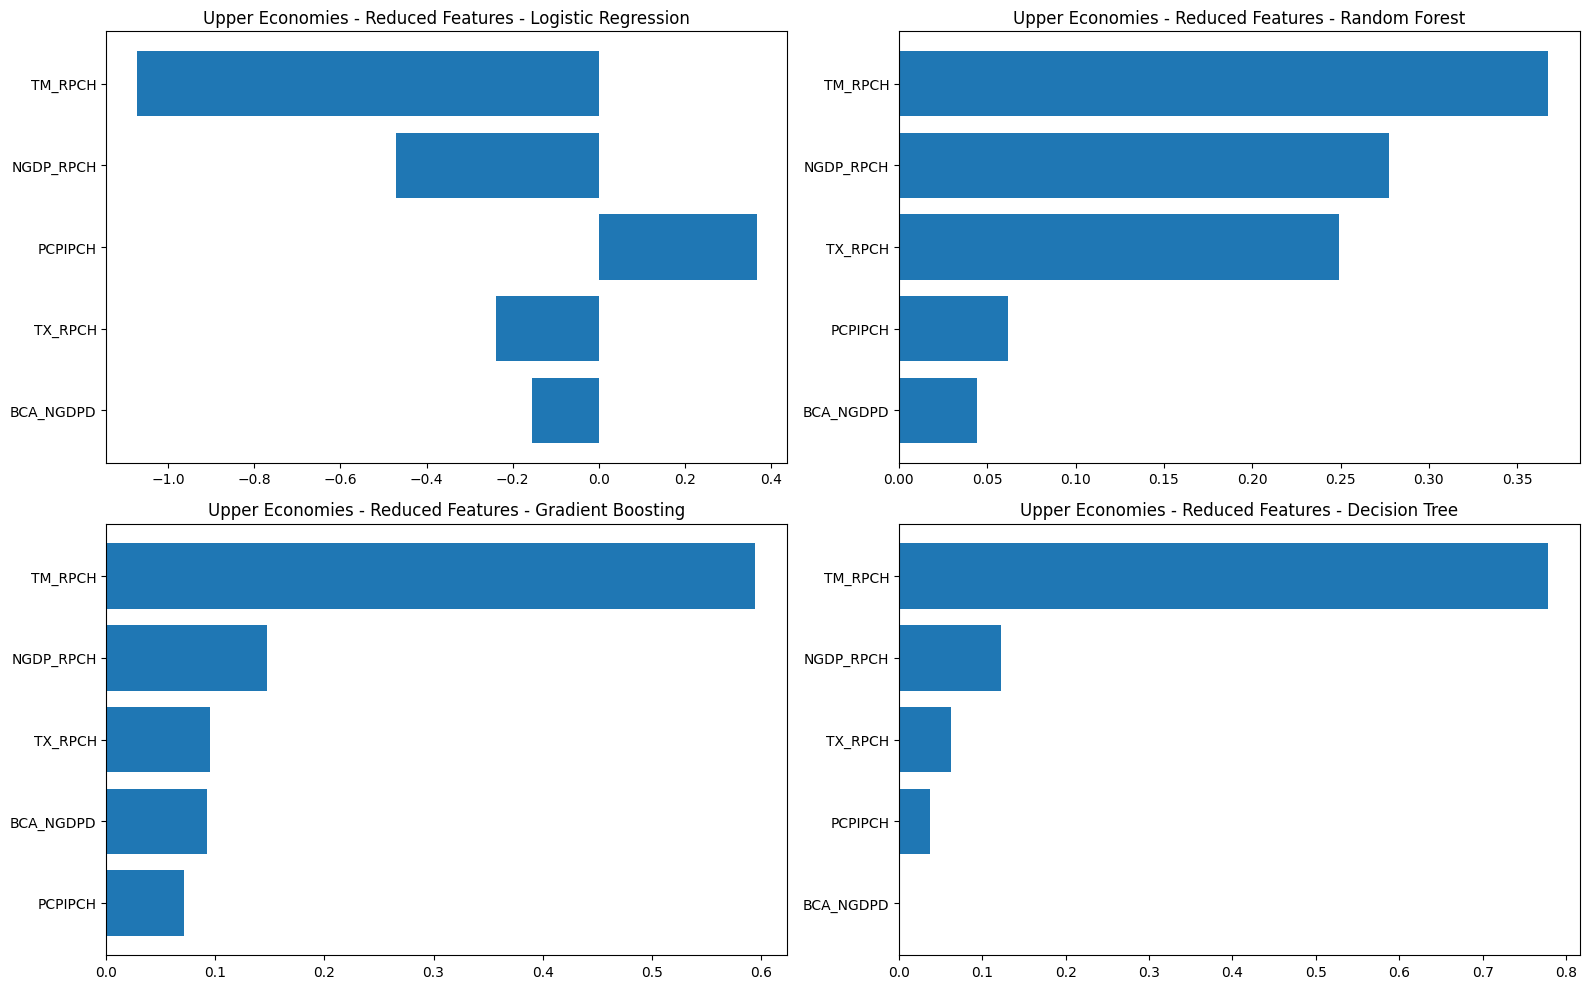

Predictions for Upper Economies (Reduced Features):
      Logistic Regression  Random Forest  Gradient Boosting  Decision Tree  \
Year                                                                         
2025                    0              0                  0              0   
2025                    0              0                  0              0   
2025                    0              0                  0              0   
2025                    1              0                  0              0   
2025                    1              1                  1              1   
...                   ...            ...                ...            ...   
2030                    1              0                  0              0   
2030                    0              0                  0              0   
2030                    0              0                  0              0   
2030                    1              0                  0              0   
2030        

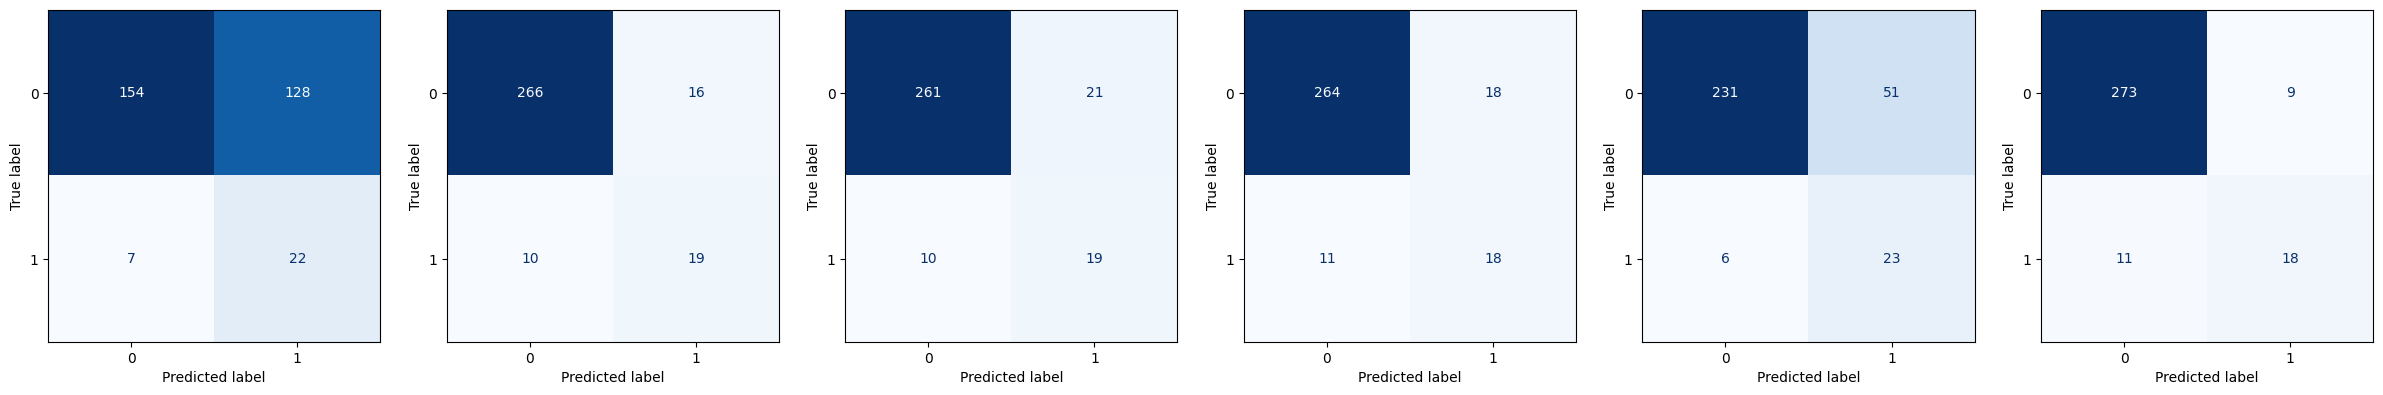

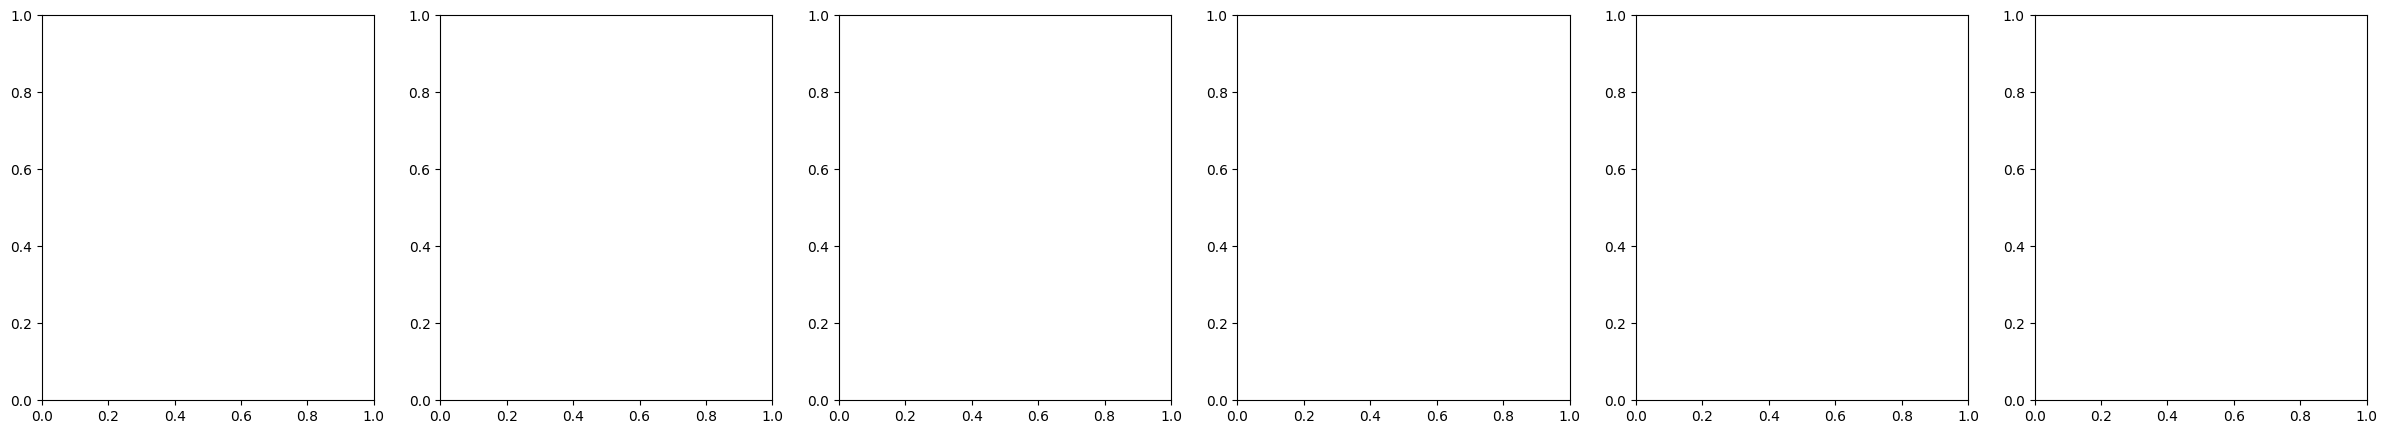

In [27]:
X_upper = df_Upper_Economies[selected_features]
y_upper = df_Upper_Economies["Recession"]

split_index_upper = int(len(X_upper) * 0.8)
X_train_upper = X_upper.iloc[:split_index_upper]
X_test_upper = X_upper.iloc[split_index_upper:]
y_train_upper = y_upper.iloc[:split_index_upper]
y_test_upper = y_upper.iloc[split_index_upper:]

# ✅ Unpack all three return values
models_upper, summary_df_upper, confusion_mats_upper = train_all_models(
    X_train_upper, y_train_upper, X_test_upper, y_test_upper, threshold=0.5
)

print("Upper Economies Accuracy (Reduced Features):")
print(summary_df_upper)

# Feature importance
plot_feature_importance(models_upper, feature_names=selected_features, 
                        title_prefix="Upper Economies - Reduced Features - ")

# Predictions
X_predict_upper_reduced = df_predict_upper[selected_features]
predictions_upper_reduced = make_predictions(models_upper, X_predict_upper_reduced, threshold=0.5)
print("Predictions for Upper Economies (Reduced Features):")
print(predictions_upper_reduced)

# ✅ Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_upper, summary_df_upper, threshold=0.5)


## Lower Economies - Reduced Features

Lower Economies Accuracy (Reduced Features):
                     Train Accuracy  Test Accuracy  Precision    Recall  \
Logistic Regression        0.731884       0.497110   0.123711  0.857143   
Random Forest              0.800000       0.895954   0.409091  0.642857   
Gradient Boosting          0.824638       0.895954   0.409091  0.642857   
Decision Tree              0.781159       0.786127   0.219512  0.642857   
SVM                        0.786957       0.872832   0.357143  0.714286   
Ensemble                   0.802899       0.907514   0.450000  0.642857   

                           F1  
Logistic Regression  0.216216  
Random Forest        0.500000  
Gradient Boosting    0.500000  
Decision Tree        0.327273  
SVM                  0.476190  
Ensemble             0.529412  


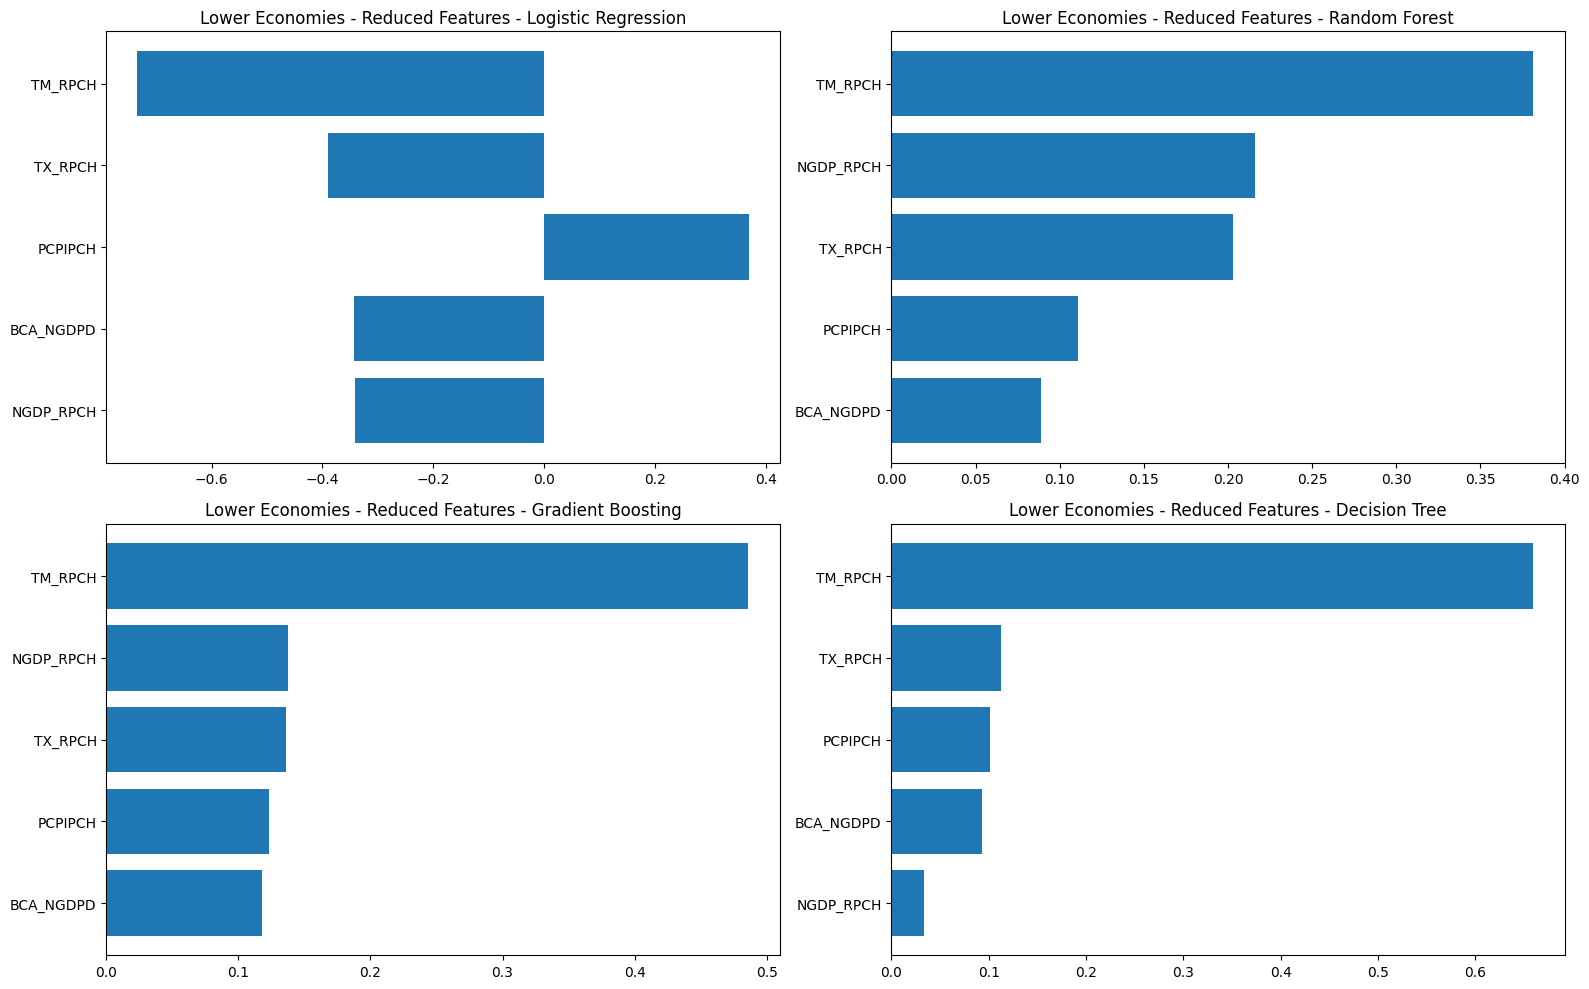

Predictions for Lower Economies (Reduced Features):
      Logistic Regression  Random Forest  Gradient Boosting  Decision Tree  \
Year                                                                         
2025                    1              0                  0              0   
2025                    0              0                  0              0   
2025                    0              0                  0              0   
2025                    1              0                  0              0   
2025                    0              0                  0              0   
...                   ...            ...                ...            ...   
2030                    1              0                  0              0   
2030                    1              0                  0              0   
2030                    1              0                  0              0   
2030                    1              0                  0              1   
2030        

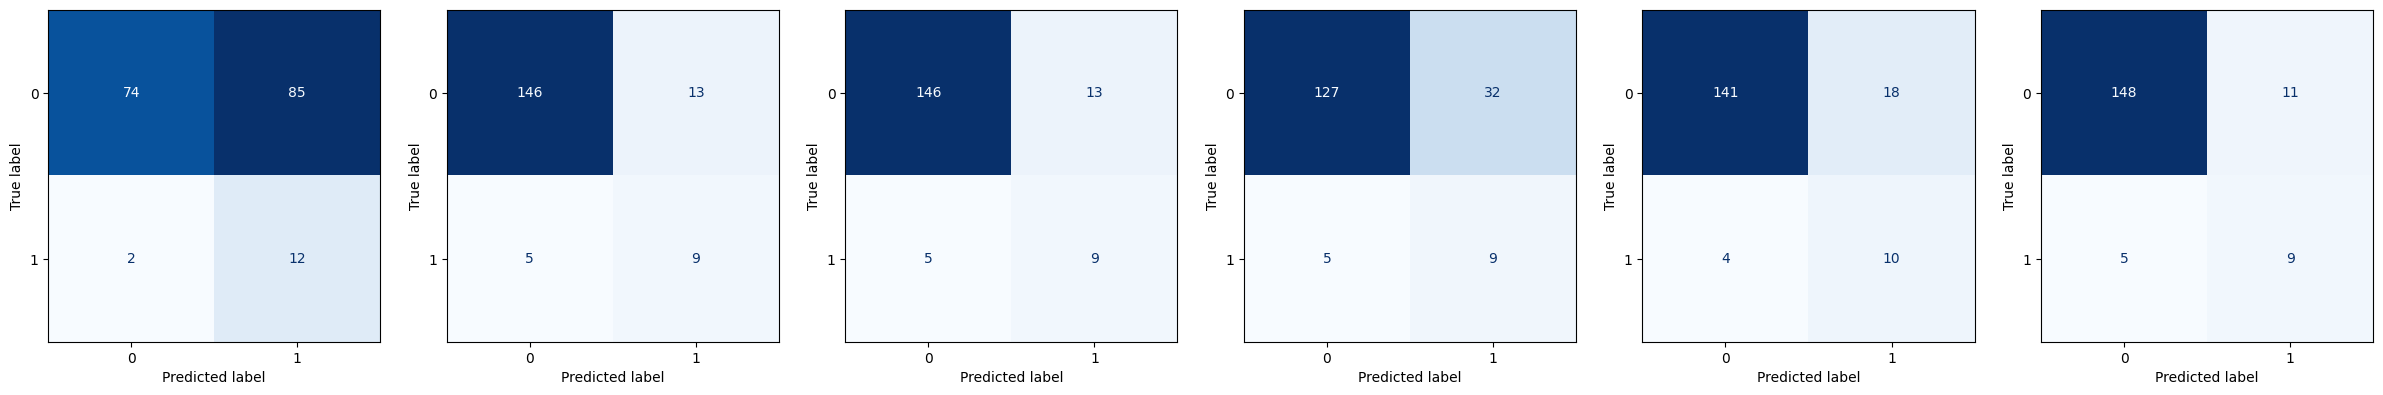

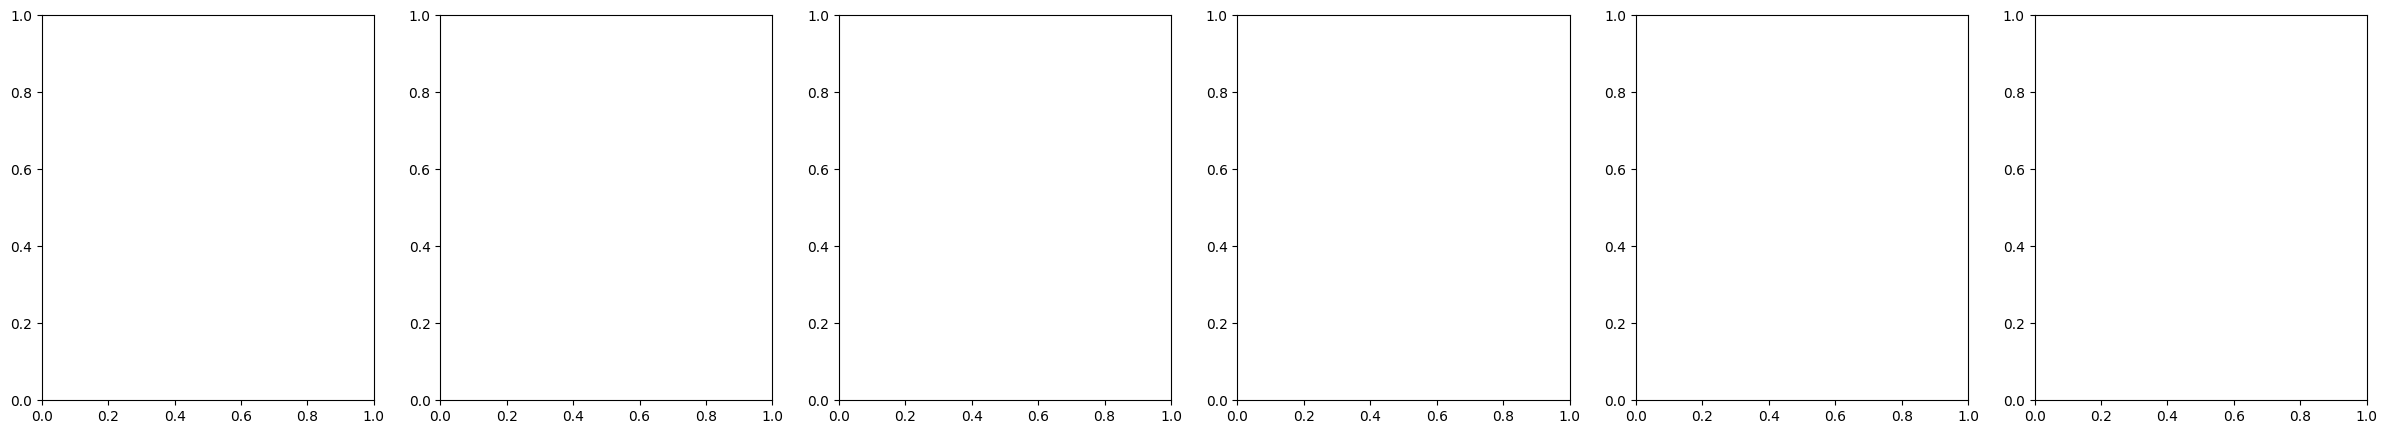

In [28]:
X_lower = df_Lower_Economies[selected_features]
y_lower = df_Lower_Economies["Recession"]

split_index_lower = int(len(X_lower) * 0.8)
X_train_lower = X_lower.iloc[:split_index_lower]
X_test_lower = X_lower.iloc[split_index_lower:]
y_train_lower = y_lower.iloc[:split_index_lower]
y_test_lower = y_lower.iloc[split_index_lower:]

# ✅ Unpack all three return values
models_lower, summary_df_lower, confusion_mats_lower = train_all_models(
    X_train_lower, y_train_lower, X_test_lower, y_test_lower, threshold=0.5
)

print("Lower Economies Accuracy (Reduced Features):")
print(summary_df_lower)

# Feature importance
plot_feature_importance(models_lower, feature_names=selected_features, 
                        title_prefix="Lower Economies - Reduced Features - ")

# Predictions
X_predict_lower_reduced = df_predict_lower[selected_features]
predictions_lower_reduced = make_predictions(models_lower, X_predict_lower_reduced, threshold=0.5)
print("Predictions for Lower Economies (Reduced Features):")
print(predictions_lower_reduced)

# ✅ Show confusion matrices (all in one window)
show_confusion_matrices(confusion_mats_lower, summary_df_lower, threshold=0.5)
